### Overview

Author: akudilcz

This notebook provides an exploration of audio data from animals, performing analysis through statistical analysis and visualisation of audio samples.  It shows a number of ways of processing audio files to create 'features' that could be used to classify the sound within the audio sample.

#### Pre-requisites 

#### Data to run this notebook

This notebook explores a data set that is stored on the Deakin teams channel here:

[DataSets Folder](https://deakin365.sharepoint.com/:f:/r/sites/DataBytes2/Shared%20Documents/Project%20Echo/DataSets?csf=1&web=1&e=oxQZWj)

This dataset was not uploaded to git to keep the repository light weight.  This notebook assumes the dataset has been mapped to your local drive.  In order the run this notebook you'll need to update the 'DATASET_PATH' system parameter below to point to your mapped one drive path.

##### Development environment is conda based

This notebook requires a conda environment setup in accordance with [Data Science Environment Setup](https://github.com/stephankokkas/Project-Echo/tree/main/src). 

In [1]:
# disable warnings to tidy up output
import warnings
warnings.filterwarnings("ignore")

# some basic libraries 
from platform import python_version
import numpy as np
import os
import random

# plot support
import matplotlib.pyplot as plt

# tensorflow support
import tensorflow as tf
import tensorflow_io as tfio

# scipy
import scipy

# reading audio datasets
import librosa
import librosa.display

# turn off tensorflow warnings
tf.get_logger().setLevel('ERROR')

# turn off absl warnings
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


# print system information
print('Python Version        : ', python_version())
print('TensorFlow Version    : ', tf.__version__)
print('TensorFlow IO Version : ', tfio.__version__)
print('Librosa Version       : ', librosa.__version__)
print('GPU Detection         : ', tf.config.list_physical_devices('GPU'))

2023-04-25 18:06:58.141607: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 18:06:58.698106: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Python Version        :  3.10.6
TensorFlow Version    :  2.12.0
TensorFlow IO Version :  0.32.0
Librosa Version       :  0.10.0.post2
GPU Detection         :  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-04-25 18:06:59.483527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-25 18:06:59.500946: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-25 18:06:59.500996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# below code adapted from:
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [3]:
# set system parameters
DATASET_PATH  = '/mnt/d/data/bc/'
SAMPLE_RATE   = 32000   # all the samples are converted to bit rate of 32000 (Samples/Second)
MIN_FREQUENCY = 16      # minimum frequency (Hz) for the Fast Fourier Transform related functions
MAX_FREQUENCY = 4096*3  # minimum frequency (Hz) for the Fast Fourier Transform related functions
HOP_LENGTH    = 128     # the number of samples to slide spectrogram window along the audio samples
NUMBER_FFT    = 2048    # the number of FFT to execute within a single spectrogram window
NUMBER_MELS   = 128     # the number of Mel-Spectrogram groups to split the frequency dimension
CLIP_LENGTH   = 10      # only look at 10 seconds of clip at the start of loaded audio file

# prefer dark background for plots
plt.style.use('dark_background')

In [4]:
# this function assumes that audio files are organised as follows:
# each subdirectory represents the audio sample class (or target label)
# audio files for a class all live in that subdirectory.
# this is a common layout used by TensorFlow data pipeline classes
# 
# dataset/
#    /target_1/
#       target_1_sample_1.mp3
#       target_1_sample_2.mp3
#    /target_2/
#       target_2_sample_1.mp3
#       target_2_sample_2.mp3
#    /target_3/
#       target_3_sample_1.mp3
#       target_3_sample_2.mp3

def dataset_from_dir_structure(dataset_path):
    # each subdir represents a data class
    subfolders = [f for f in os.scandir(dataset_path) if f.is_dir()]

    dataset_filenames = []
    dataset_labels = []
    
    # dictionary of datasets grouped into classes
    target_datasets = {}
    
    for subfolder in subfolders:
        # now get all the files in the folder
        audiofiles = [f for f in os.scandir(subfolder.path) if f.is_file()]
        
        target_filenames = []
        target_labels = []
        
        for audiofile in audiofiles:
            dataset_filenames.append(audiofile.path)
            dataset_labels.append(subfolder.name)
            target_filenames.append(audiofile.path)
            target_labels.append(subfolder.name)
    
        # create per-target datasets
        target_dataset = tf.data.Dataset.from_tensor_slices((target_filenames, target_labels))
        target_datasets[subfolder.name] = target_dataset     
            
    # create the complete dataset containing all target classes
    dataset = tf.data.Dataset.from_tensor_slices((dataset_filenames, dataset_labels))
    
    return dataset, target_datasets

In [5]:
# create the dataset
file_dataset,target_datasets = dataset_from_dir_structure(DATASET_PATH)
print("Dataset Samples: ", len(file_dataset))
print("Dataset Labels : ", target_datasets.keys())

# print three elements of the file_dataset pipeline
for file, label in file_dataset.take(3):
    print ("FILE: ",file.numpy().decode("utf-8"), " LABEL: ", label.numpy().decode("utf-8"))

2023-04-25 18:06:59.676144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-25 18:06:59.676243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-25 18:06:59.676308: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-25 18:07:00.559814: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-25 18:07:00.559891: I tensorflow/compile

Dataset Samples:  524
Dataset Labels :  dict_keys(['brant', 'jabwar', 'sheowl', 'spodov', 'wiltur'])
FILE:  /mnt/d/data/bc/brant/XC112697.ogg  LABEL:  brant
FILE:  /mnt/d/data/bc/brant/XC127691.ogg  LABEL:  brant
FILE:  /mnt/d/data/bc/brant/XC143518.ogg  LABEL:  brant


2023-04-25 18:07:01.177277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [524]
	 [[{{node Placeholder/_1}}]]


In [6]:
# this function converts filename to actual audio 2d array data
def load_audio_file(audio_file, label):
    
    # load audio as an IOTensor
    audio = tfio.audio.AudioIOTensor(audio_file, dtype=tf.float32)
    
    # convert to tensor and keep only 10 seconds worth of the left channel
    audio_t = audio.to_tensor()[0:audio.rate*CLIP_LENGTH,0]
    
    return audio_t, audio.rate, label

# scale the audio amplitude to range(-1,1)
def scale_audio(audio,rate, label):
    audio = audio - tf.reduce_min(audio)
    audio = 2.0*(audio / (tf.reduce_max(audio)+tf.keras.backend.epsilon()))-1.0
    return audio,rate,label

# standardise the sample rate through re-sampling
def standardise_sample_rate(audio, rate, label):
    audio = tfio.audio.resample(audio, rate_in=tf.cast(rate, tf.int64), rate_out=SAMPLE_RATE)
    return audio,tf.Variable(SAMPLE_RATE),label

# make a data pipeline
def make_data_pipeline(dataset):
    # now to create a pipeline to load the audio file
    audio_dataset = (dataset
                    .map(load_audio_file)
                    .map(standardise_sample_rate)
                    .map(scale_audio)
                    .cache()
                    .repeat()
                    )
    return audio_dataset
    
audio_dataset = make_data_pipeline(file_dataset)

# check the data loaded ok
for audio, rate, label in audio_dataset.take(3):
    audio_np = audio.numpy()
    print (audio_np.shape, rate.numpy(), np.min(audio_np), np.max(audio_np), label.numpy().decode("utf-8"))

2023-04-25 18:07:01.247003: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
2023-04-25 18:07:01.626144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype resource
	 [[{{node Placeholder/_4}}]]


(320000,) 32000 -1.0 0.99999976 brant
(320000,) 32000 -1.0 0.99999976 brant
(320000,) 32000 -1.0 0.99999964 brant


2023-04-25 18:07:02.122266: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


#### Visualisation of sound as amplitude vs time

The following three plots show how the sound sample varies over time.  When looking at only the amplitude data we get a sense of how loud the sound sample is at each point, but it visually unclear which part of this sample identifies the animal sounds and which parts are simply background noise. 

Considering this data as a 'vector', sound samples are highly dimensional - one way of interpreting this data would be as a vector of 10 seconds x 32000 Samples / Second = 320,000 samples.  In vector form this could in theory feed into a DNN for classification, but would need some kind of 1D-Convolution filters to identify patterns in the time dimension.

2023-04-25 18:07:02.594078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype resource
	 [[{{node Placeholder/_4}}]]
2023-04-25 18:07:03.052712: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


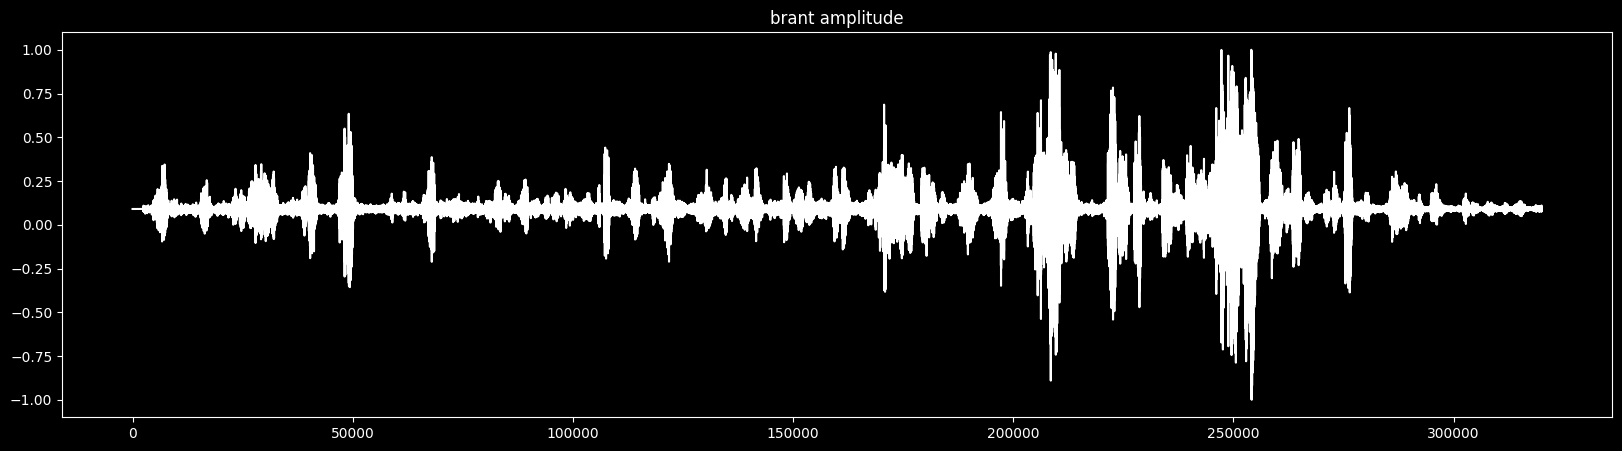

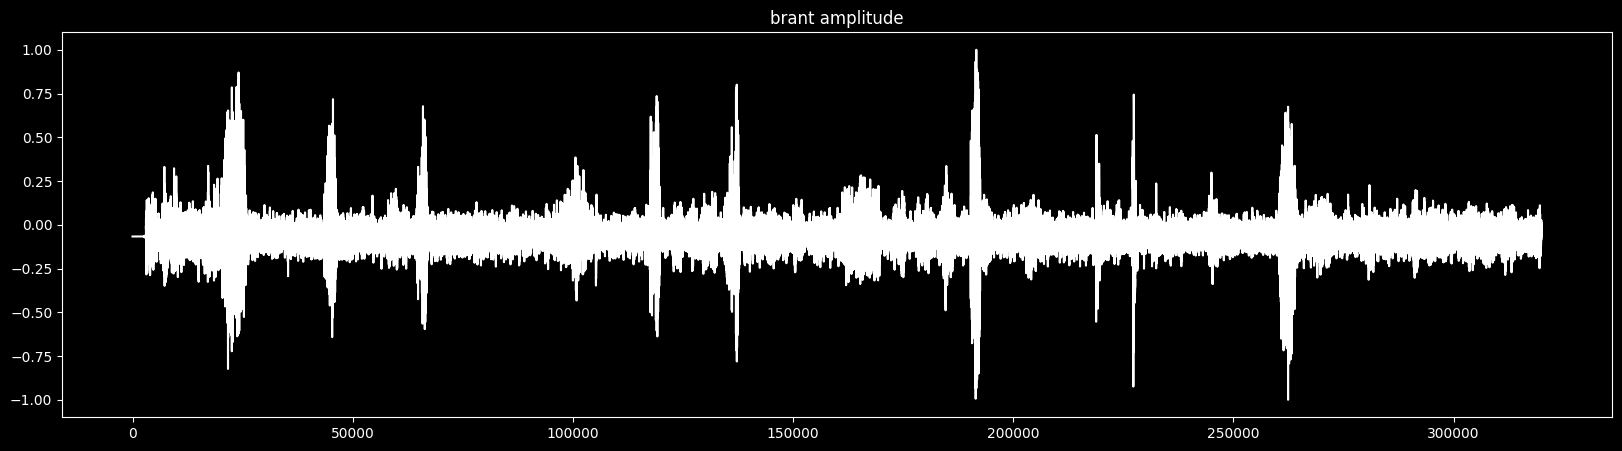

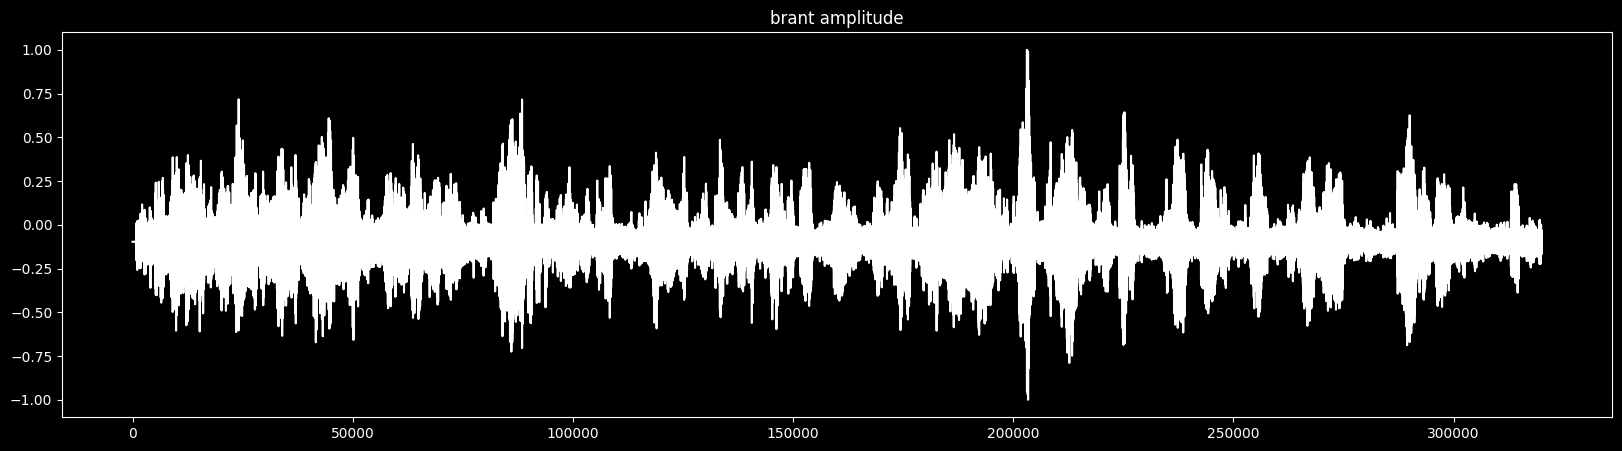

In [7]:
# plot three samples of audio
for audio, rate, label in audio_dataset.take(3):
    audio_np = audio.numpy()
    plt.figure(figsize=(20,5))
    plt.plot(audio_np, color="white")
    plt.title(label.numpy().decode("utf-8") + " amplitude")

#### Visualisation of Amplitude of the same species

The purpose of these visualisation is to perform a side-by-side comparison of the audio amplitude waveforms to see if there are any obvious similarities (patterns) between 3 samples from the same animal species. Initial observation indicates parts of the amplitude waveform exhibit similarities which may indicate this representation has some predictive power for classification tasks. 

2023-04-25 18:07:05.130015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype resource
	 [[{{node Placeholder/_4}}]]
2023-04-25 18:07:05.614779: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-04-25 18:07:06.151946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for plac

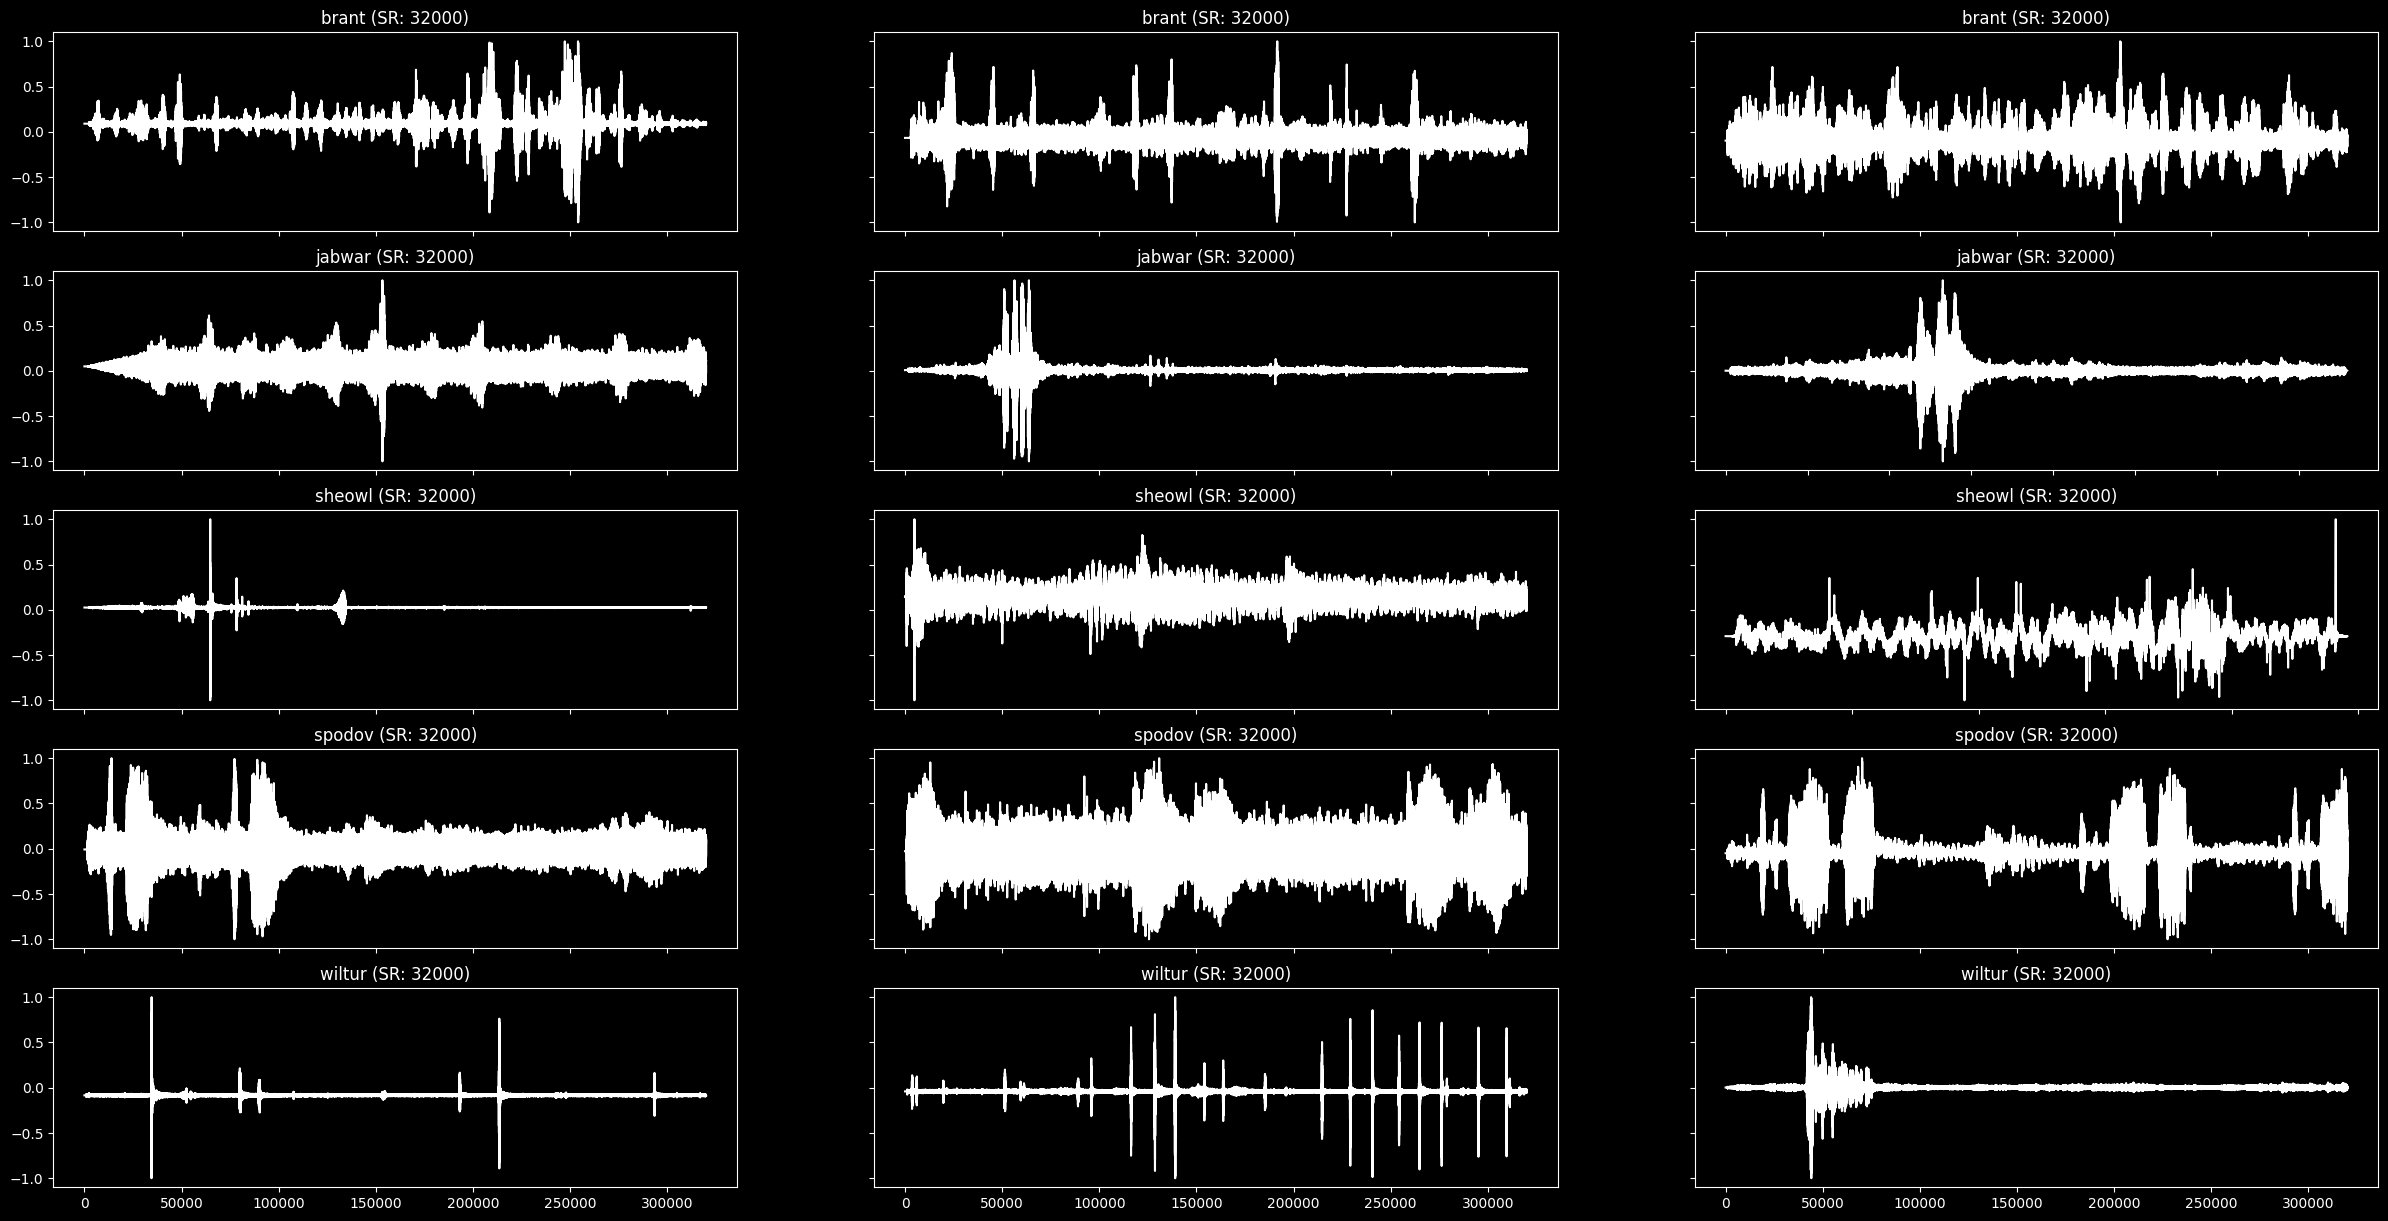

In [8]:
# plot three samples of audio from each target class
fig, axs = plt.subplots(nrows=len(target_datasets), ncols=3, figsize=(30,15))

for target_index, target in enumerate(target_datasets.keys()):
    
    # now to create a pipeline to load the audio file
    audio_dataset = make_data_pipeline(target_datasets[target])
      
    for audio_index, (audio, rate, label) in enumerate(audio_dataset.take(3)):
        audio_np = audio.numpy()
        axs[target_index, audio_index].plot(audio_np, color="white")
        axs[target_index, audio_index].set_title(label.numpy().decode("utf-8")+  " (SR: "+ str(rate.numpy())+")")
        
for ax in axs.flat:
    ax.label_outer()

In [9]:
def make_feature_plots(f_feature, title):
    # plot three samples of audio from each target class
    N_COLS=3

    fig, axs = plt.subplots(nrows=len(target_datasets), ncols=N_COLS, figsize=(30,10), sharex=True)
    plt.title(title)
    
    for target_index, target in enumerate(target_datasets.keys()):
        
        # now to create a pipeline to load the audio file
        audio_dataset = make_data_pipeline(target_datasets[target])  
        
        for audio_index, (audio, rate, label) in enumerate(audio_dataset.take(N_COLS)):
            
            # convert to numpy array
            audio_np = audio.numpy()[0:rate*CLIP_LENGTH] 
            
            # apply the feature function
            audio_feature = f_feature(audio_np, rate.numpy()) 
                                
            # show the spectrum
            librosa.display.specshow(audio_feature, 
                                    x_axis='time', 
                                    # y_axis='log', 
                                    sr=rate.numpy(), 
                                    hop_length=HOP_LENGTH,
                                    fmin=MIN_FREQUENCY, 
                                    fmax=MAX_FREQUENCY,
                                    ax=axs[target_index, audio_index])
            axs[target_index, audio_index].set_title(label.numpy().decode("utf-8"))
        
    for ax in axs.flat:
        ax.label_outer()

#### Melspectrograms visualisation of sound samples

The Melspectrogram is a spectrogram (frequency vs time) representation of the audio sample which has been generated via a technique called Fast Fourier Transform.  The data is processed to extract how much energy is present in each frequency band for each time window.  The 'Mel' part is a scaling of the result to match the way the human ear works so that different frequencies appear to be at the same distance for the same amplitude (same energy).  This somehow corrects the spectrogram to account for perception.

This Melspectrogram representation is called out in the literature review many times as having significant predictive power.  From the spectrograms below it is clear that the 'shape' of the sound is more apparent and could be learned by typical image processing layers such as 2D convolutions.  There is also a clearer separation of 'interesting' features in the sound sample vs. background noise.  Mechanisms to learn to attend to the features and ignore the noise may be useful in increase predictive power of the classification model.

2023-04-25 18:07:14.145977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype resource
	 [[{{node Placeholder/_4}}]]
2023-04-25 18:07:15.794726: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-04-25 18:07:16.866900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for plac

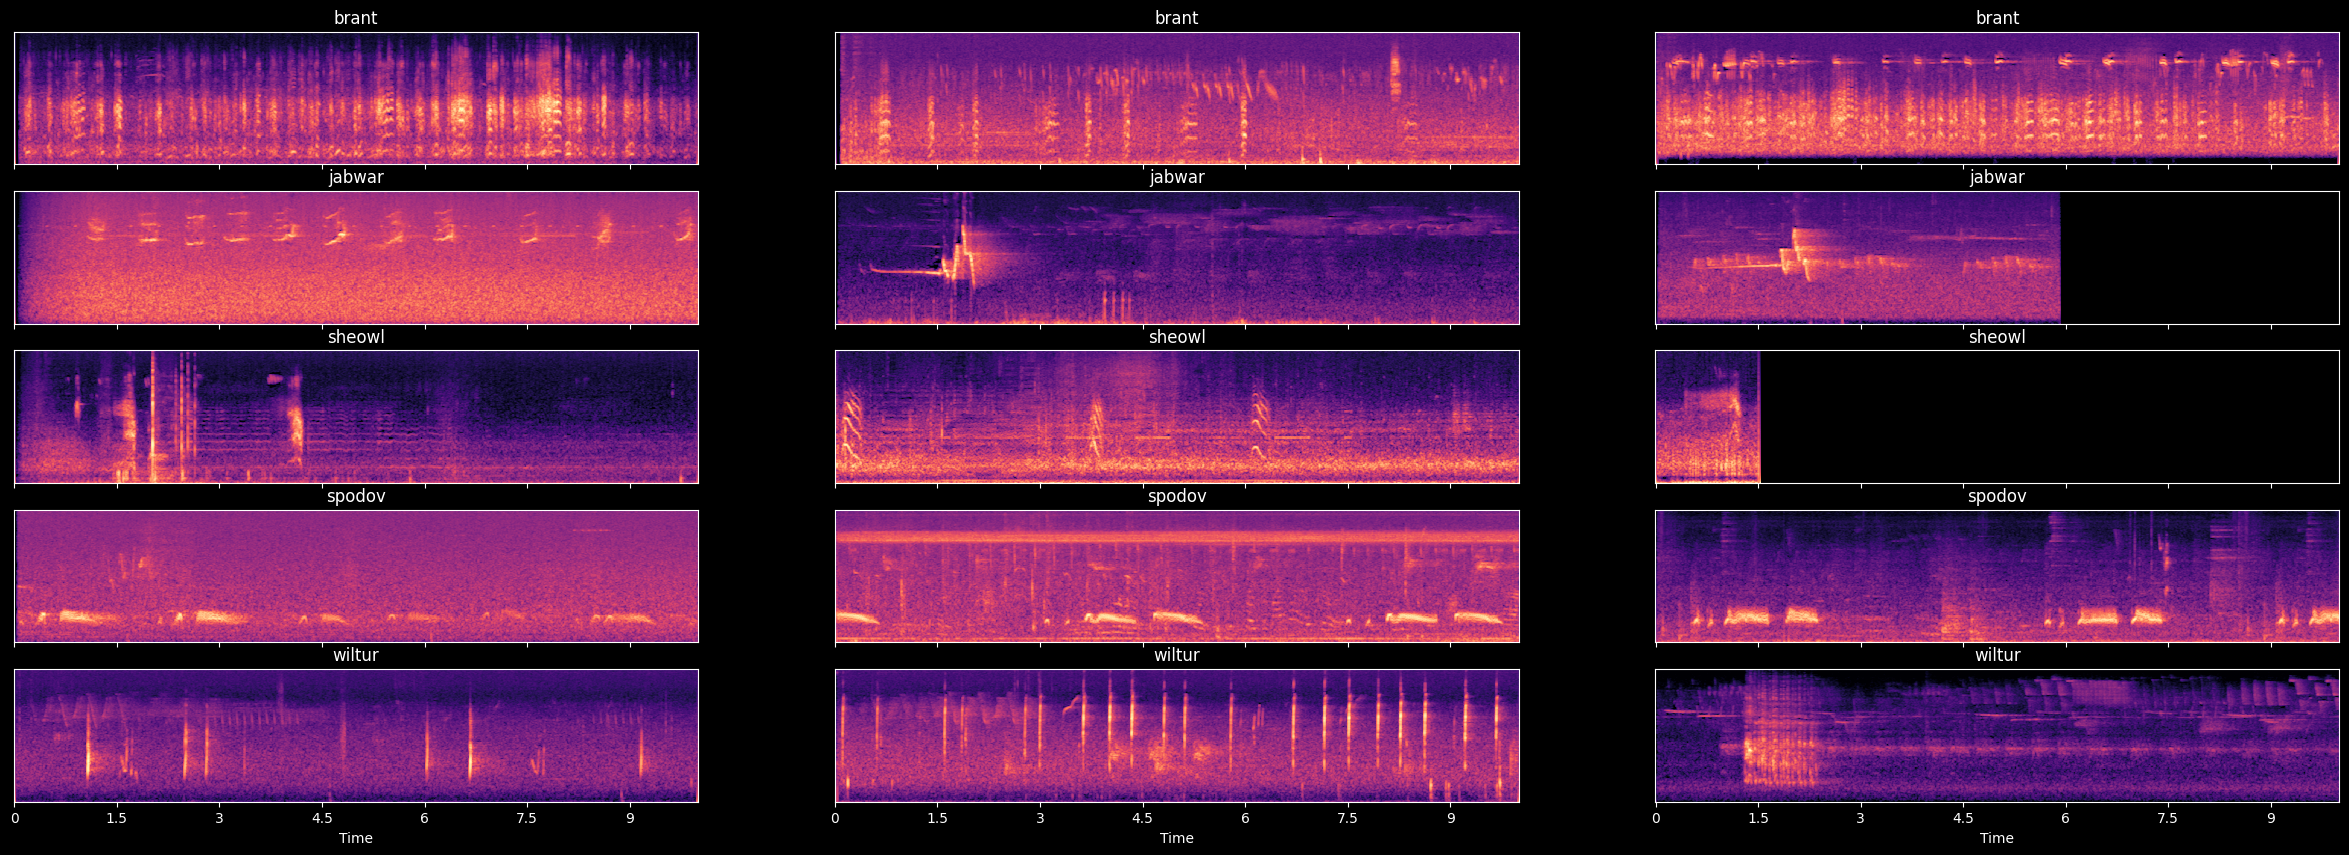

In [10]:
 # generate melspectrogram visualisation
def feature_melspectrogram(audio,rate):
    melspec = librosa.feature.melspectrogram(y=audio, 
                                            sr=rate, 
                                            S=None, 
                                            n_fft=NUMBER_FFT, 
                                            hop_length=HOP_LENGTH, 
                                            win_length=None, 
                                            window='hann', 
                                            center=True, 
                                            n_mels=NUMBER_MELS,
                                            pad_mode='constant',
                                            fmin=MIN_FREQUENCY,
                                            fmax=MAX_FREQUENCY,
                                            power=2.0)
    
    # convert to db
    melspec_db = librosa.power_to_db(melspec, ref=np.max)
    
    return melspec_db
        
make_feature_plots(lambda audio,rate: feature_melspectrogram(audio,rate), "melspectrogram")

In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.  Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. [[Wikipedia](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)].  

MFCC are a useful representation when processing sound from human voice as the frequency spacing is evenly distributed.  This makes it efficient for representing voice type sounds as human voice system is also spaced the same way (Mel-frequency bands).  For animal sounds it is unclear if this representation would be efficient way to extract features (as animal frequency ranges differ substantially from typical human voice frequency range).  

2023-04-25 18:07:25.825083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype resource
	 [[{{node Placeholder/_4}}]]
2023-04-25 18:07:26.277737: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-04-25 18:07:26.936654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for plac

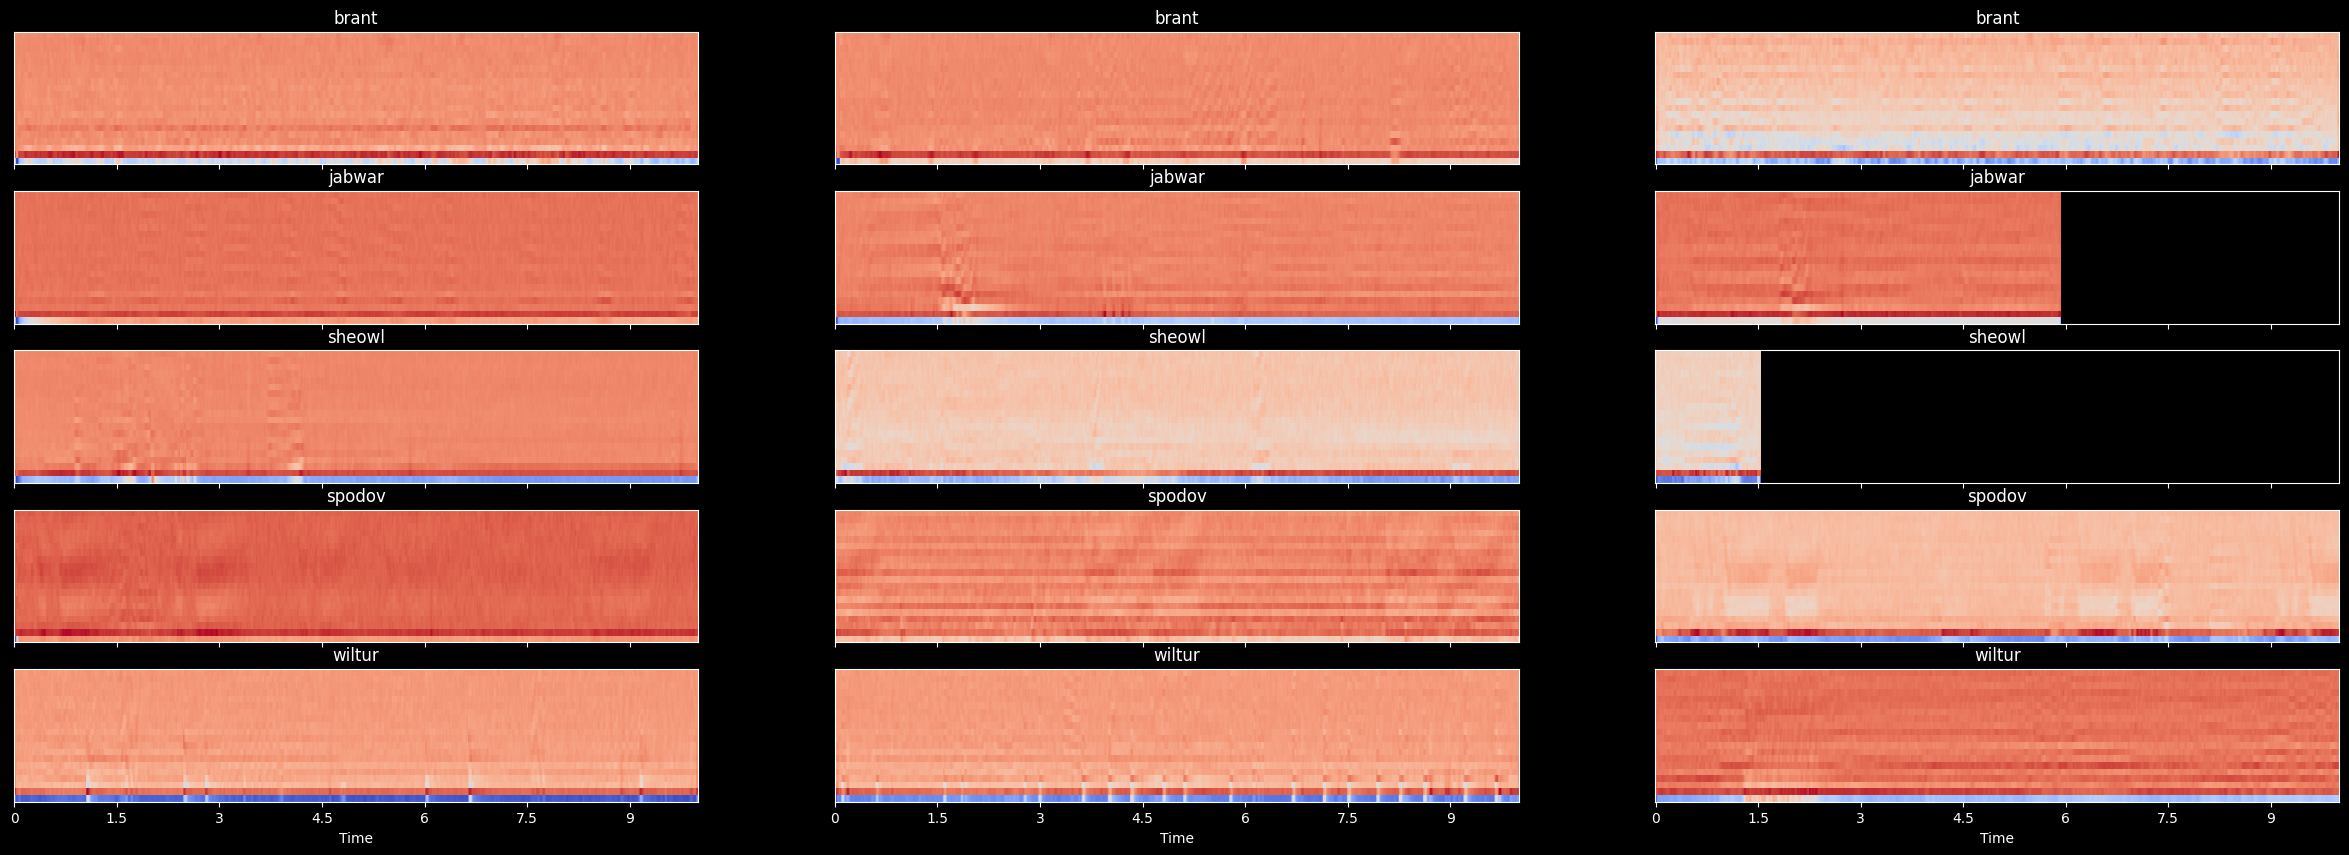

In [11]:
 # generate mfcc visualisation
def feature_mfcc(audio,rate):
    mfcc = librosa.feature.mfcc(y=audio, 
                                sr=rate, 
                                S=None, 
                                n_fft=NUMBER_FFT, 
                                hop_length=HOP_LENGTH, 
                                win_length=None, 
                                window='hann', 
                                center=True, 
                                n_mels=NUMBER_MELS,
                                pad_mode='constant',
                                fmin=MIN_FREQUENCY,
                                fmax=MAX_FREQUENCY,
                                power=2.0)
    return mfcc
        
make_feature_plots(lambda audio,rate: feature_mfcc(audio,rate), "mfcc")

#### Spectral Contrast within spectrogram

Spectral Contrast works by deviding the frequency dimension into 'bands' and the contrasting the mean, top and bottom qualitiles (in terms of energy) within each band.  High contrast imply narrow band signal whilst low contrast indicates noise.  More information can be found here: https://librosa.org/doc/main/generated/librosa.feature.spectral_contrast.html

This representation may be useful to inform a classification model about which parts of the input a relevant (signal) vs which parts are not relevant (noise).

2023-04-25 18:07:33.731510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype resource
	 [[{{node Placeholder/_4}}]]
2023-04-25 18:07:34.282454: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-04-25 18:07:34.708153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for plac

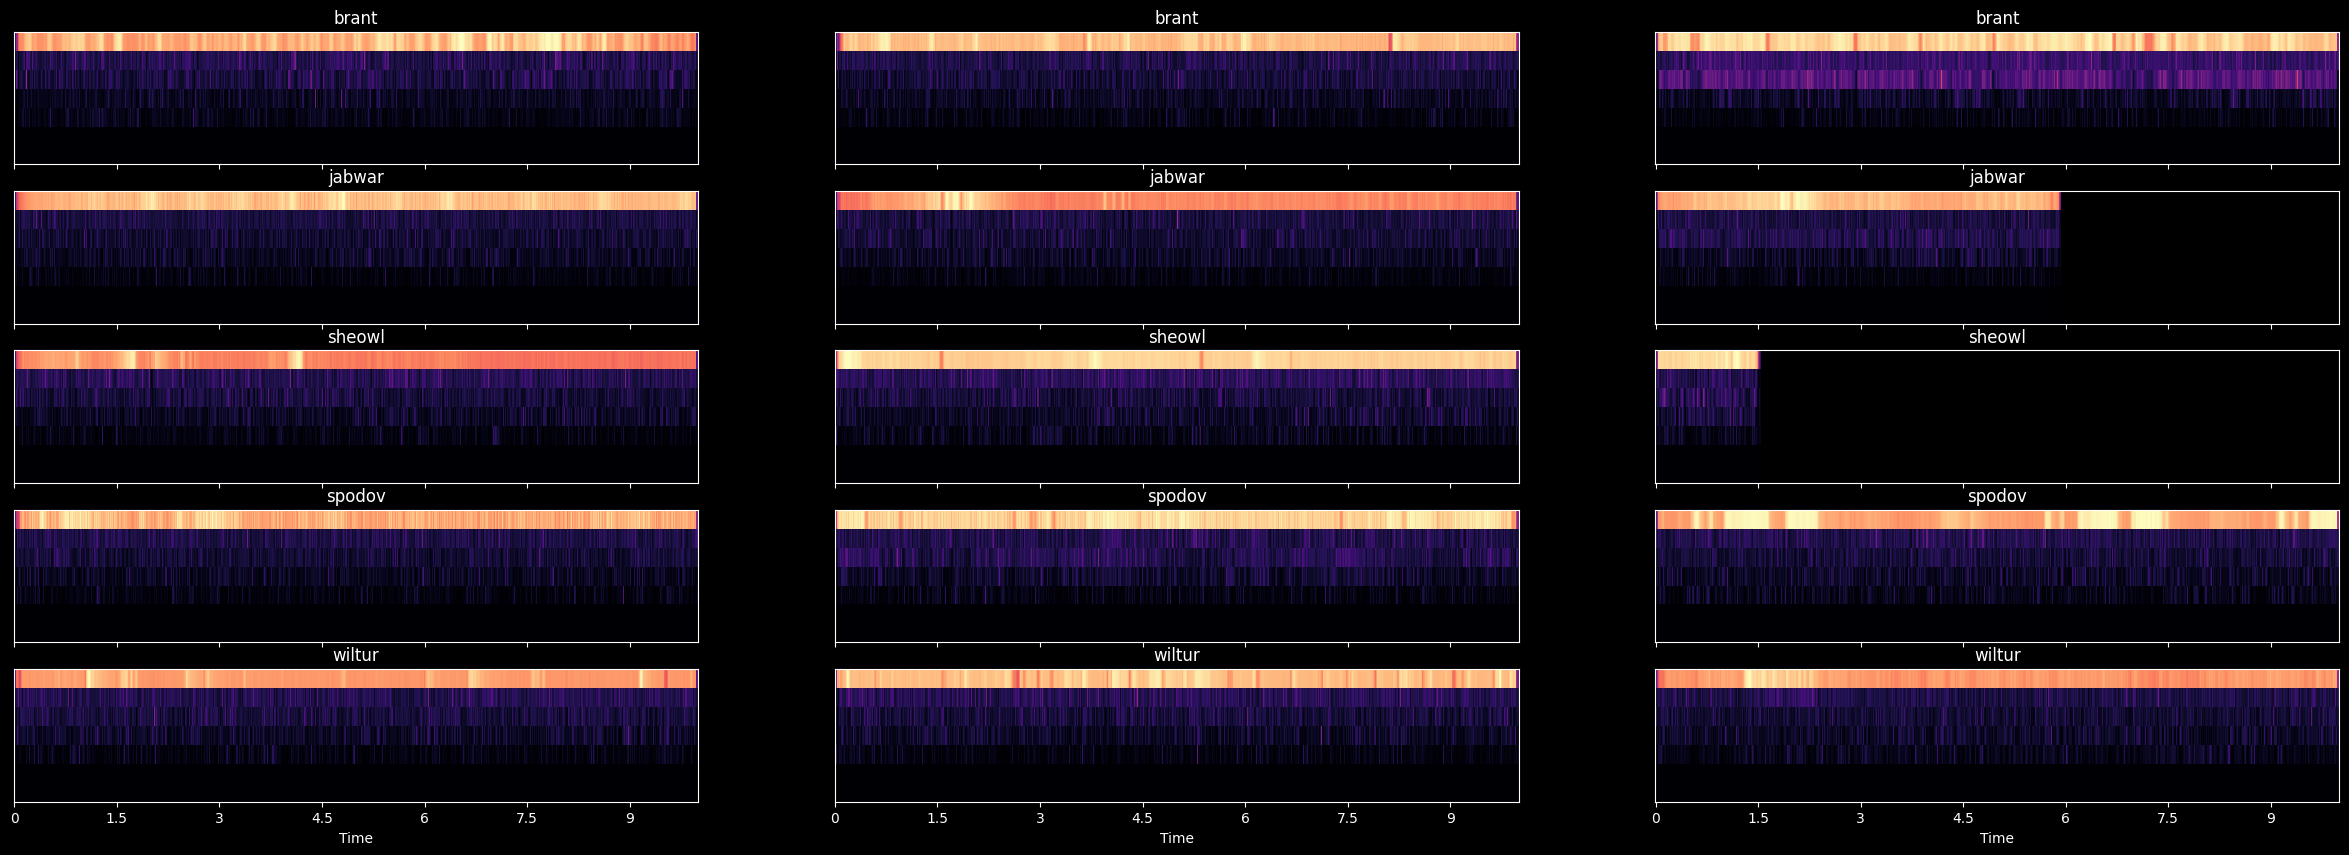

In [12]:
 # generate spectral_contrast visualisation
def feature_spectral_contrast(audio,rate):
    feature = librosa.feature.spectral_contrast(y=audio, 
                                sr=rate, 
                                S=None, 
                                n_fft=NUMBER_FFT, 
                                hop_length=HOP_LENGTH, 
                                win_length=None, 
                                window='hann', 
                                center=True, 
                                pad_mode='constant',
                                fmin=MIN_FREQUENCY,
                                )
    return feature
        
make_feature_plots(lambda audio,rate: feature_spectral_contrast(audio,rate), "spectral_contrast")

#### Using Descrete Cosign Transform with FFT
The scipy.fft.dct() method can compute the discrete cosine transform by selecting different types of sequences and return the transformed array by using this method - an effective way to convert the images to arrays.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.dct.html

In literatue review, this technique helped derive the short-term energy, zero-crosssing rate, and bandwidth by extracting the Cepstral Coefficients.

2023-04-25 18:07:41.202188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype resource
	 [[{{node Placeholder/_4}}]]
2023-04-25 18:07:41.737312: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-04-25 18:07:42.613571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for plac

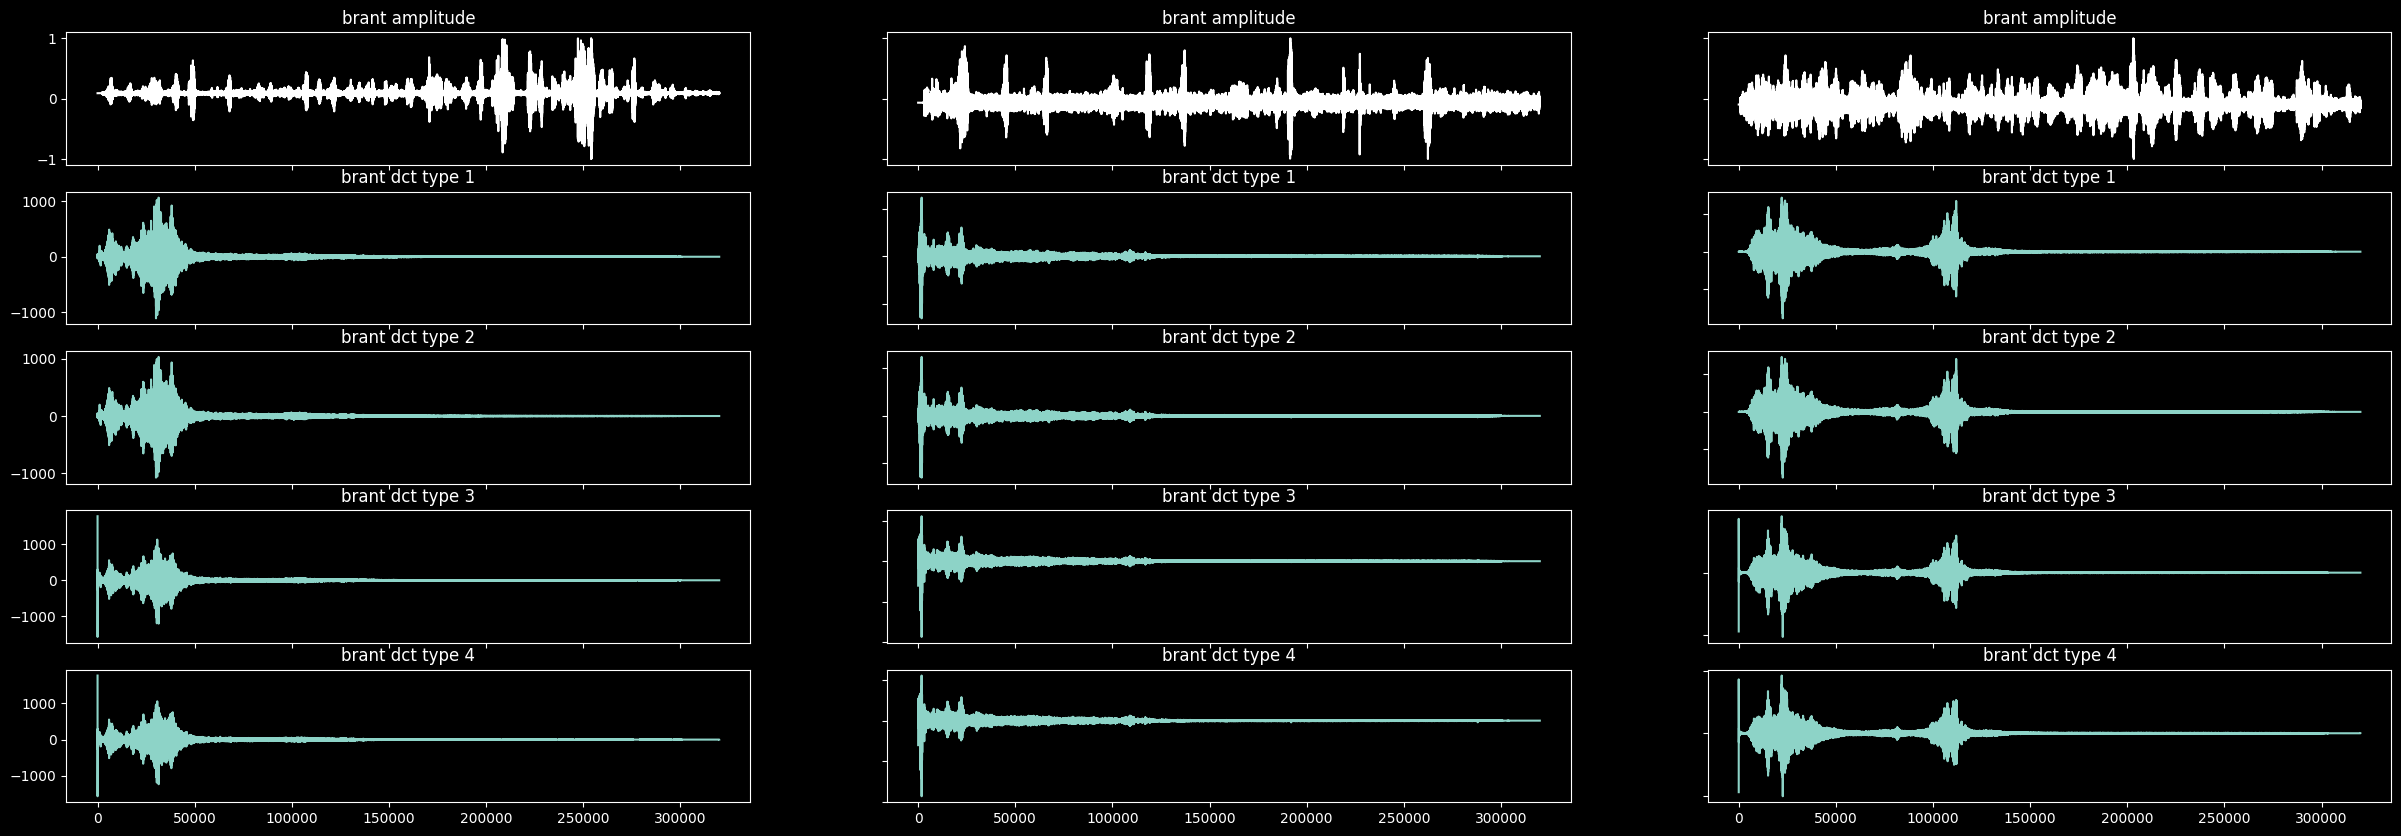

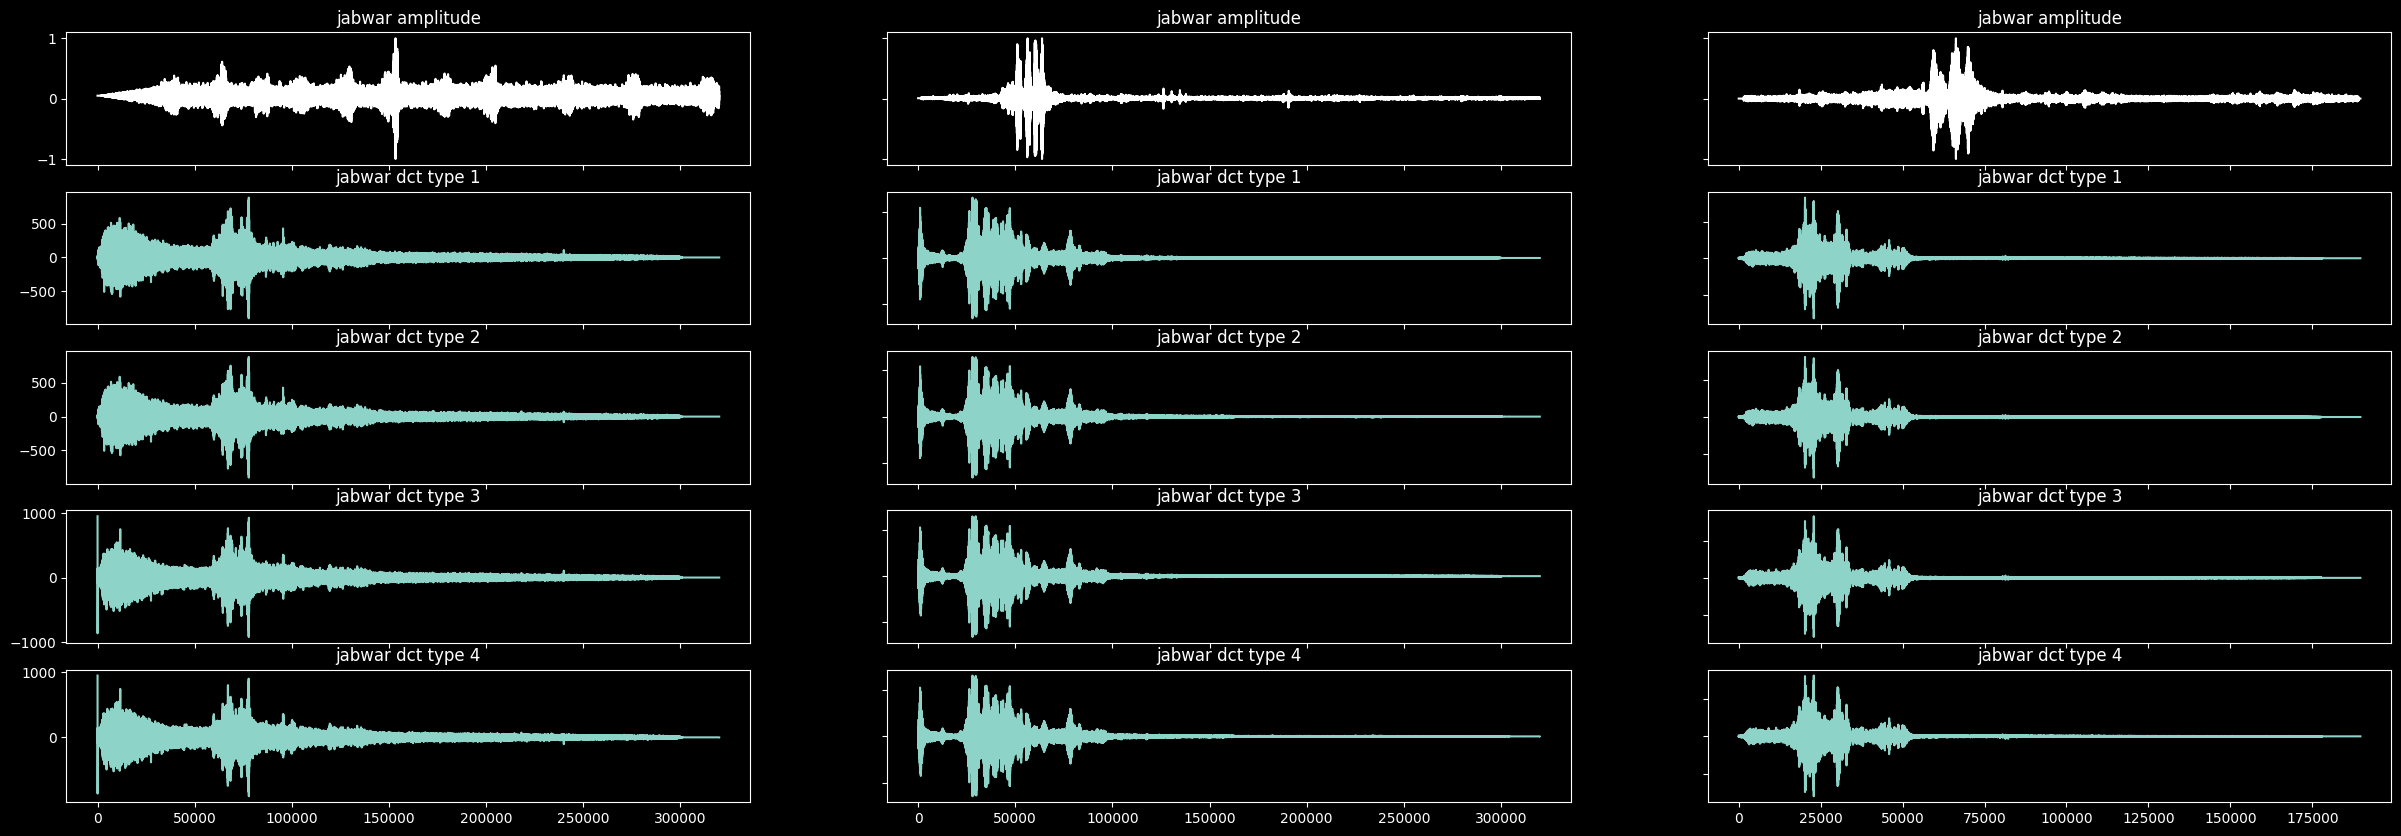

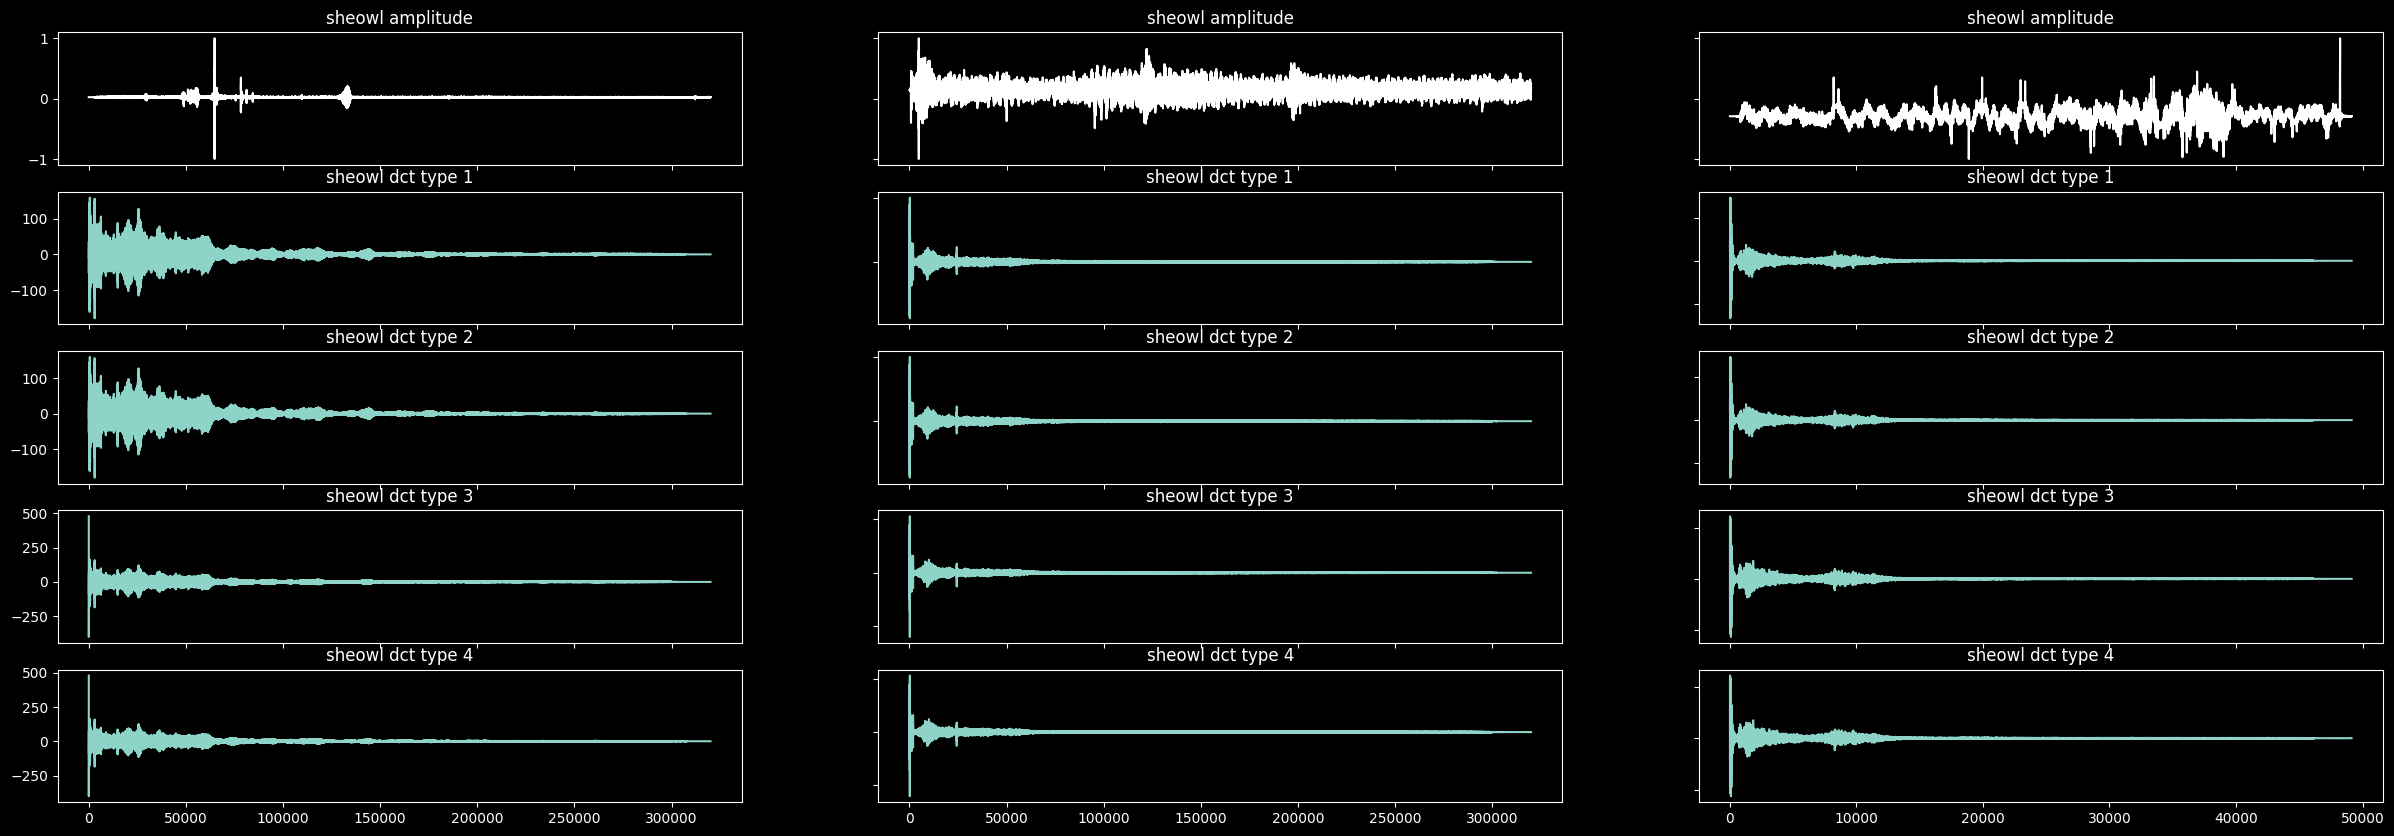

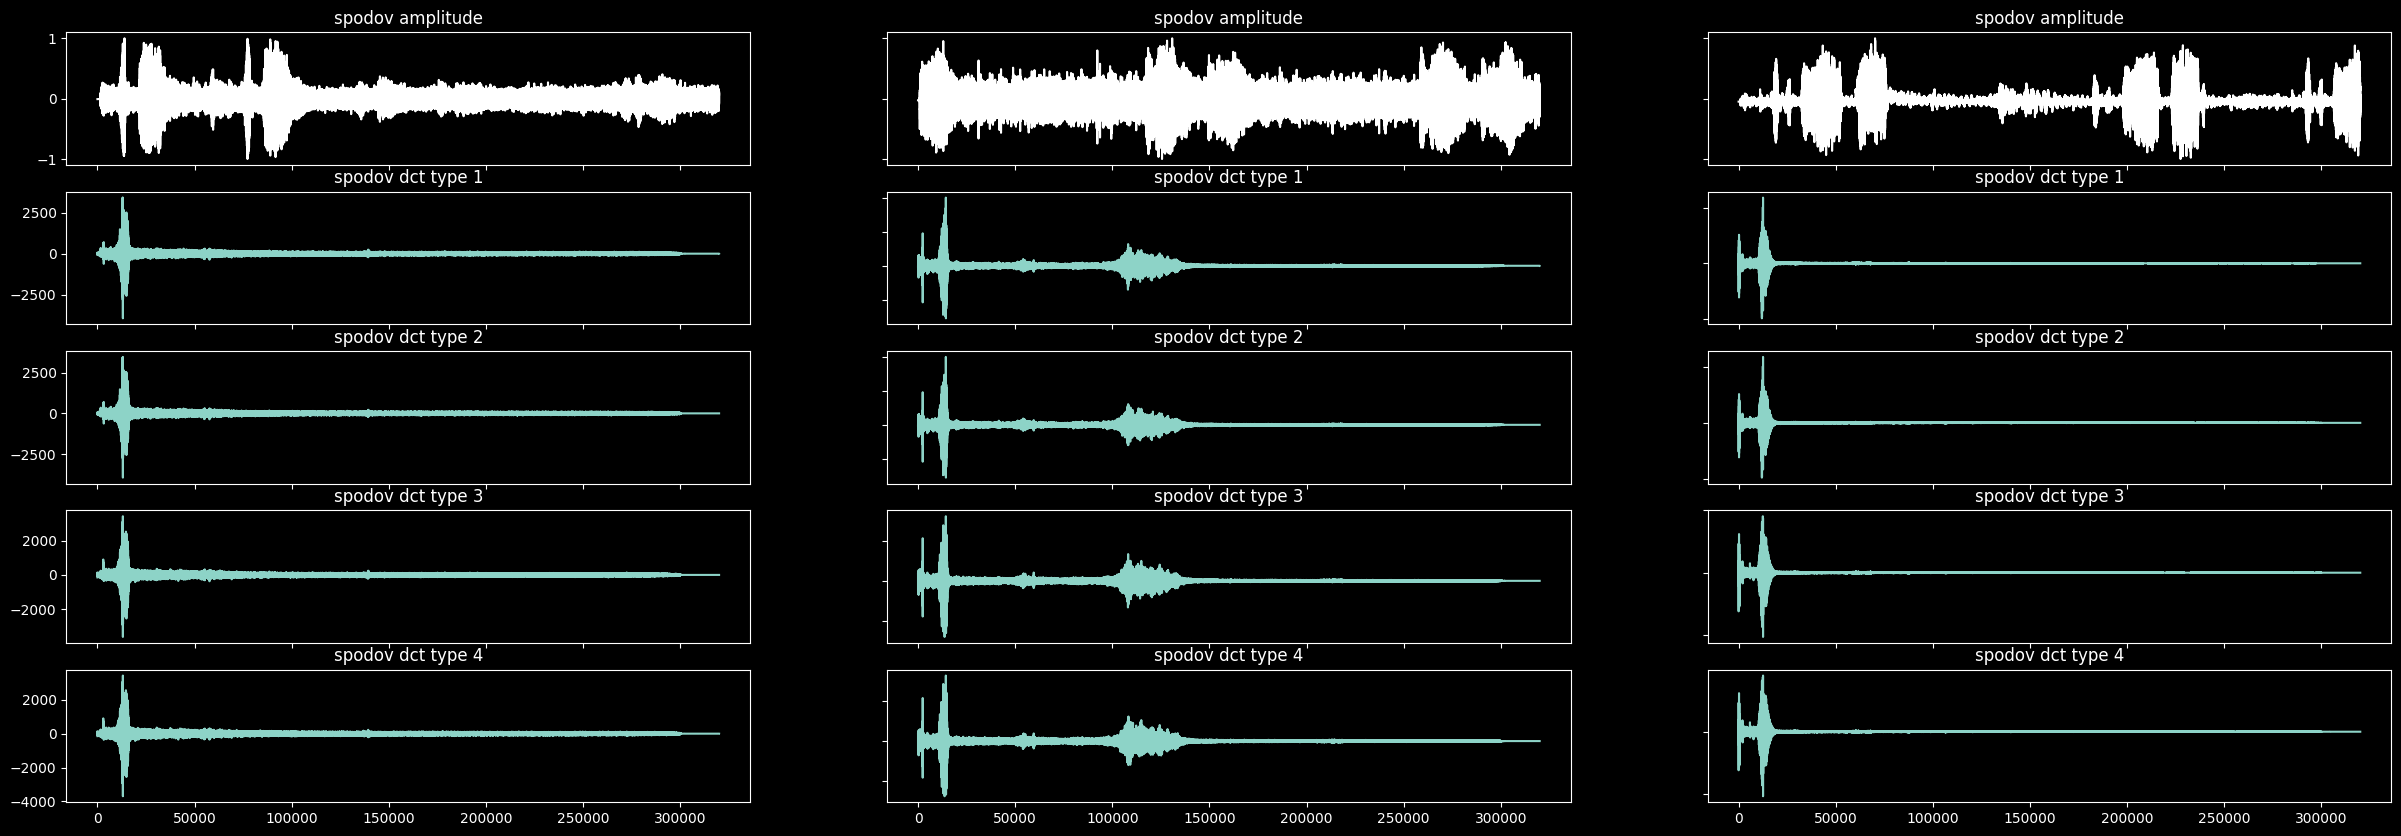

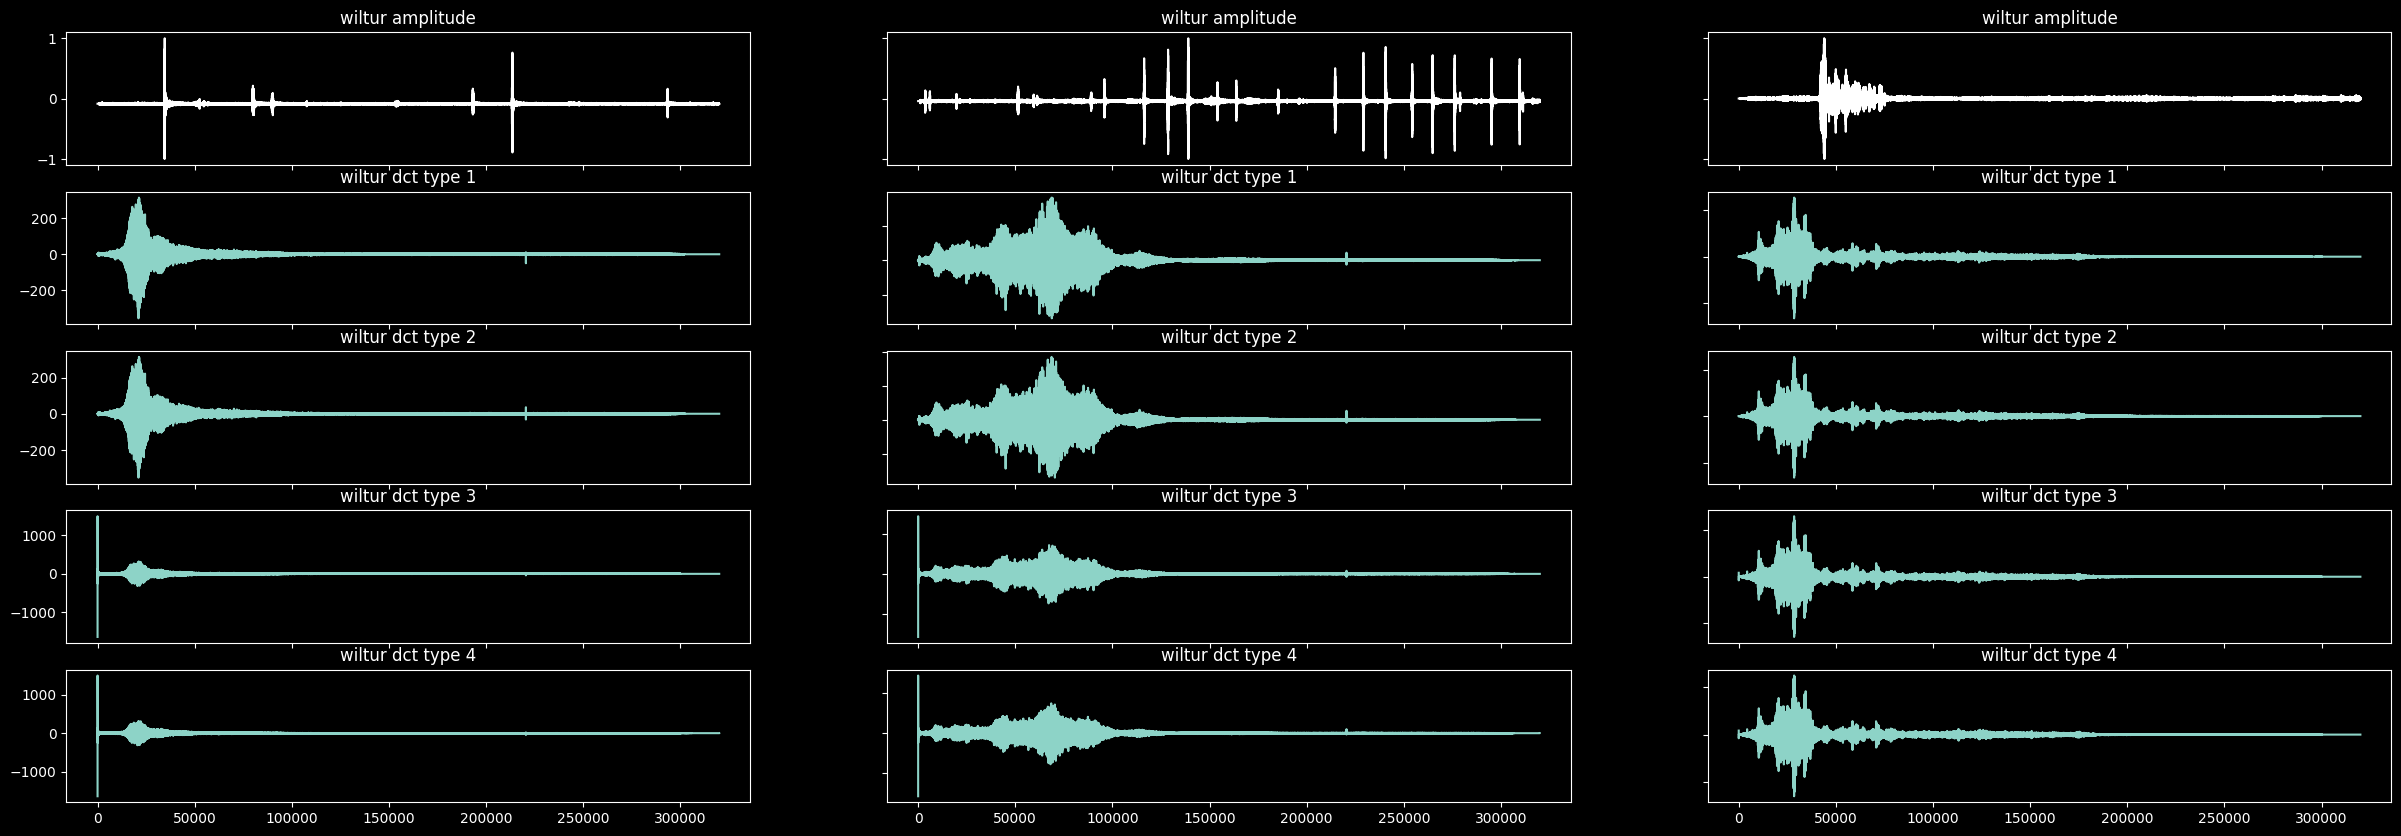

In [13]:
# plot three samples of audio from each target class
N_COLS=3

for target_index, target in enumerate(target_datasets.keys()):
    
    # create a pipeline to load the audio file
    audio_dataset = make_data_pipeline(target_datasets[target])
    
    # 5 rows per audio clip (3 columns one for each clip)
    fig, axs = plt.subplots(nrows=5, ncols=N_COLS, figsize=(30,10))
    
    for audio_index, (audio, rate, label) in enumerate(audio_dataset.take(N_COLS)):    

        # convert to numpy array
        audio_np = audio.numpy()[0:rate*CLIP_LENGTH]  
        axs[0, audio_index].plot(audio_np[10:], color="white")    
        axs[0, audio_index].set_title(label.numpy().decode("utf-8") + " amplitude") 
        
        # plot dct type 1
        result = scipy.fft.dct(audio_np, type=1, n=None, axis=-1, norm=None, overwrite_x=False, workers=None)
        axs[1, audio_index].plot(result[10:])
        axs[1, audio_index].set_title(label.numpy().decode("utf-8") + " dct type 1") 
        
        # plot dct type 2
        result = scipy.fft.dct(audio_np, type=2, n=None, axis=-1, norm=None, overwrite_x=False, workers=None)
        axs[2, audio_index].plot(result[10:])
        axs[2, audio_index].set_title(label.numpy().decode("utf-8") + " dct type 2") 
        
        # plot dct type 3
        result = scipy.fft.dct(audio_np, type=3, n=None, axis=-1, norm=None, overwrite_x=False, workers=None)
        axs[3, audio_index].plot(result[10:])
        axs[3, audio_index].set_title(label.numpy().decode("utf-8") + " dct type 3") 
        
        # plot dct type 4
        result = scipy.fft.dct(audio_np, type=4, n=None, axis=-1, norm=None, overwrite_x=False, workers=None)
        axs[4, audio_index].plot(result[10:])     
        axs[4, audio_index].set_title(label.numpy().decode("utf-8") + " dct type 4")   
        
    for ax in axs.flat:
        ax.label_outer()  

#### Visualisation of zero-crossing points in the audio signal

This signal processing technique attempts to identify where the signal is collapsing and passing through the 'zero' point or horixontal zero axis.  This may be useful to identify the start and end of parts of the signal so that only relevant parts are used for training models.

However, looking at the variety of plots below, the zero crossing result is not always a good indicator when the original signal contains alot of noise.  The noise seems to prevent the algorithm from determining zero crossing point clearly.

2023-04-25 18:08:00.346362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype resource
	 [[{{node Placeholder/_4}}]]
2023-04-25 18:08:00.801656: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-04-25 18:08:01.418872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for plac

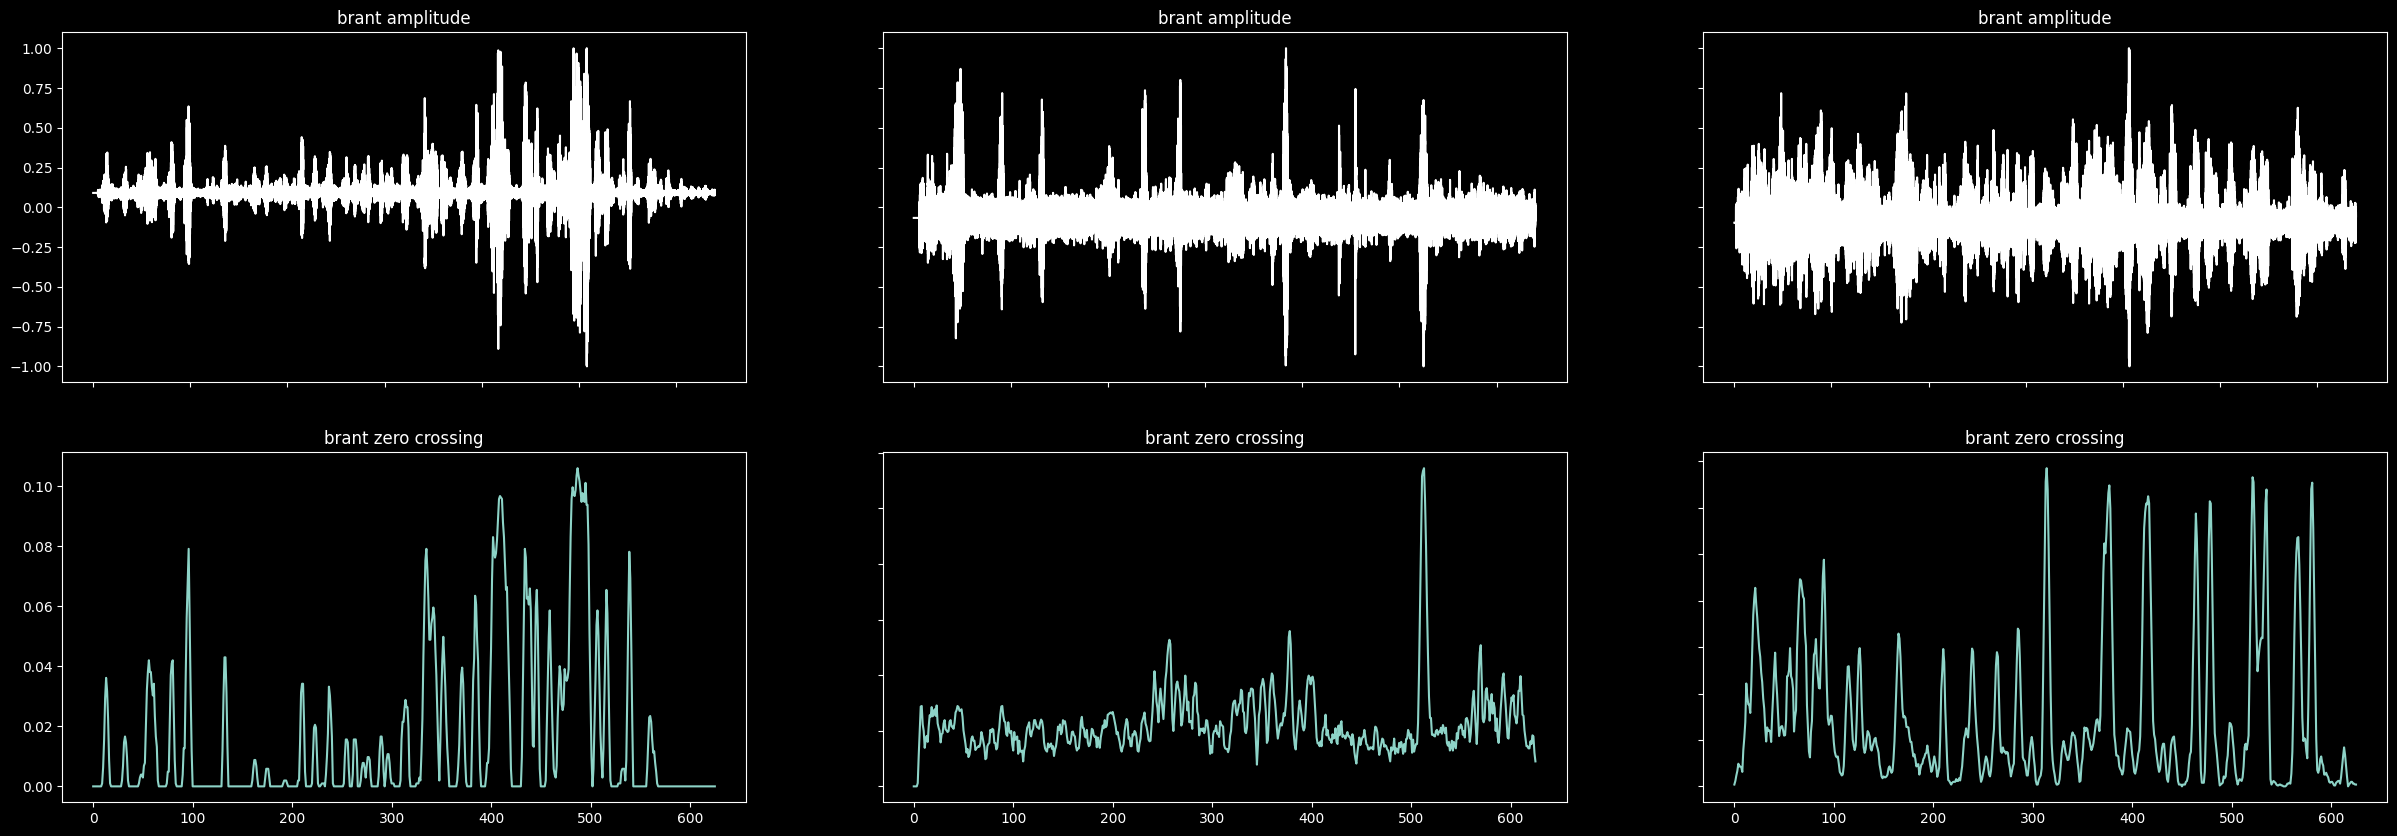

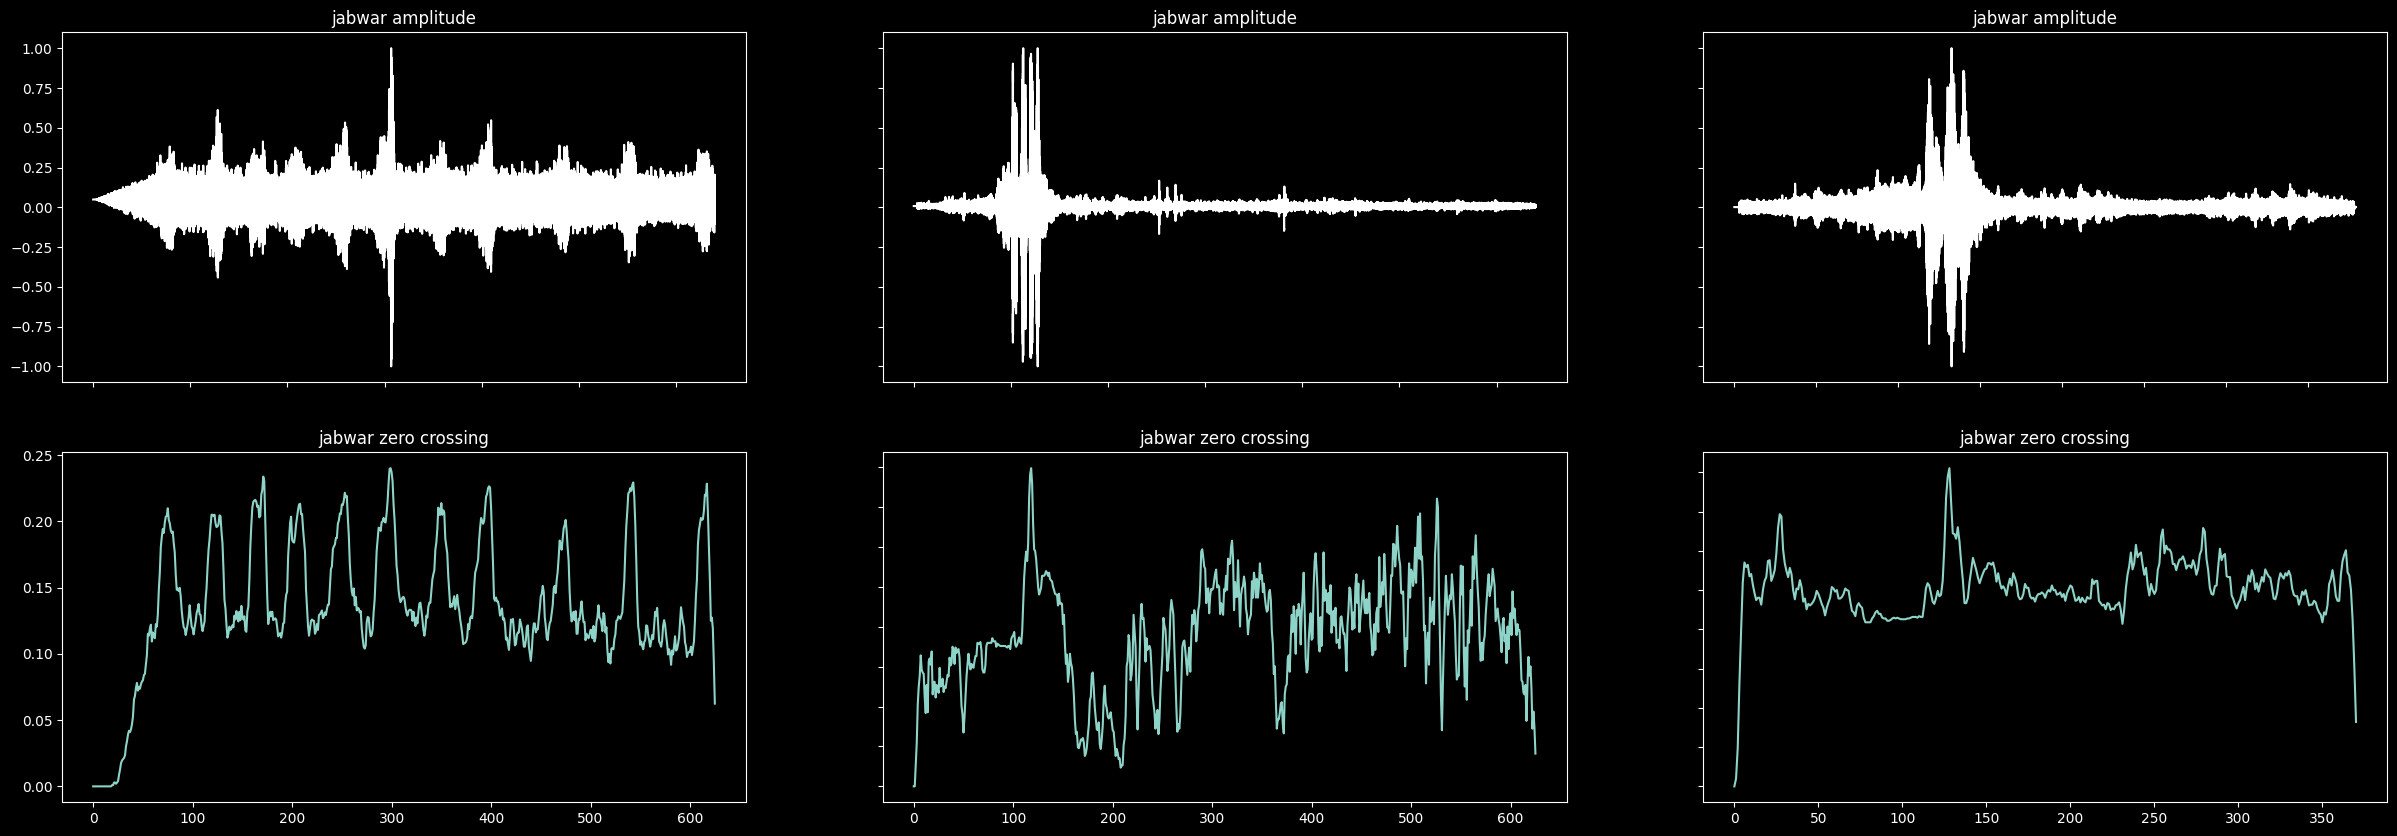

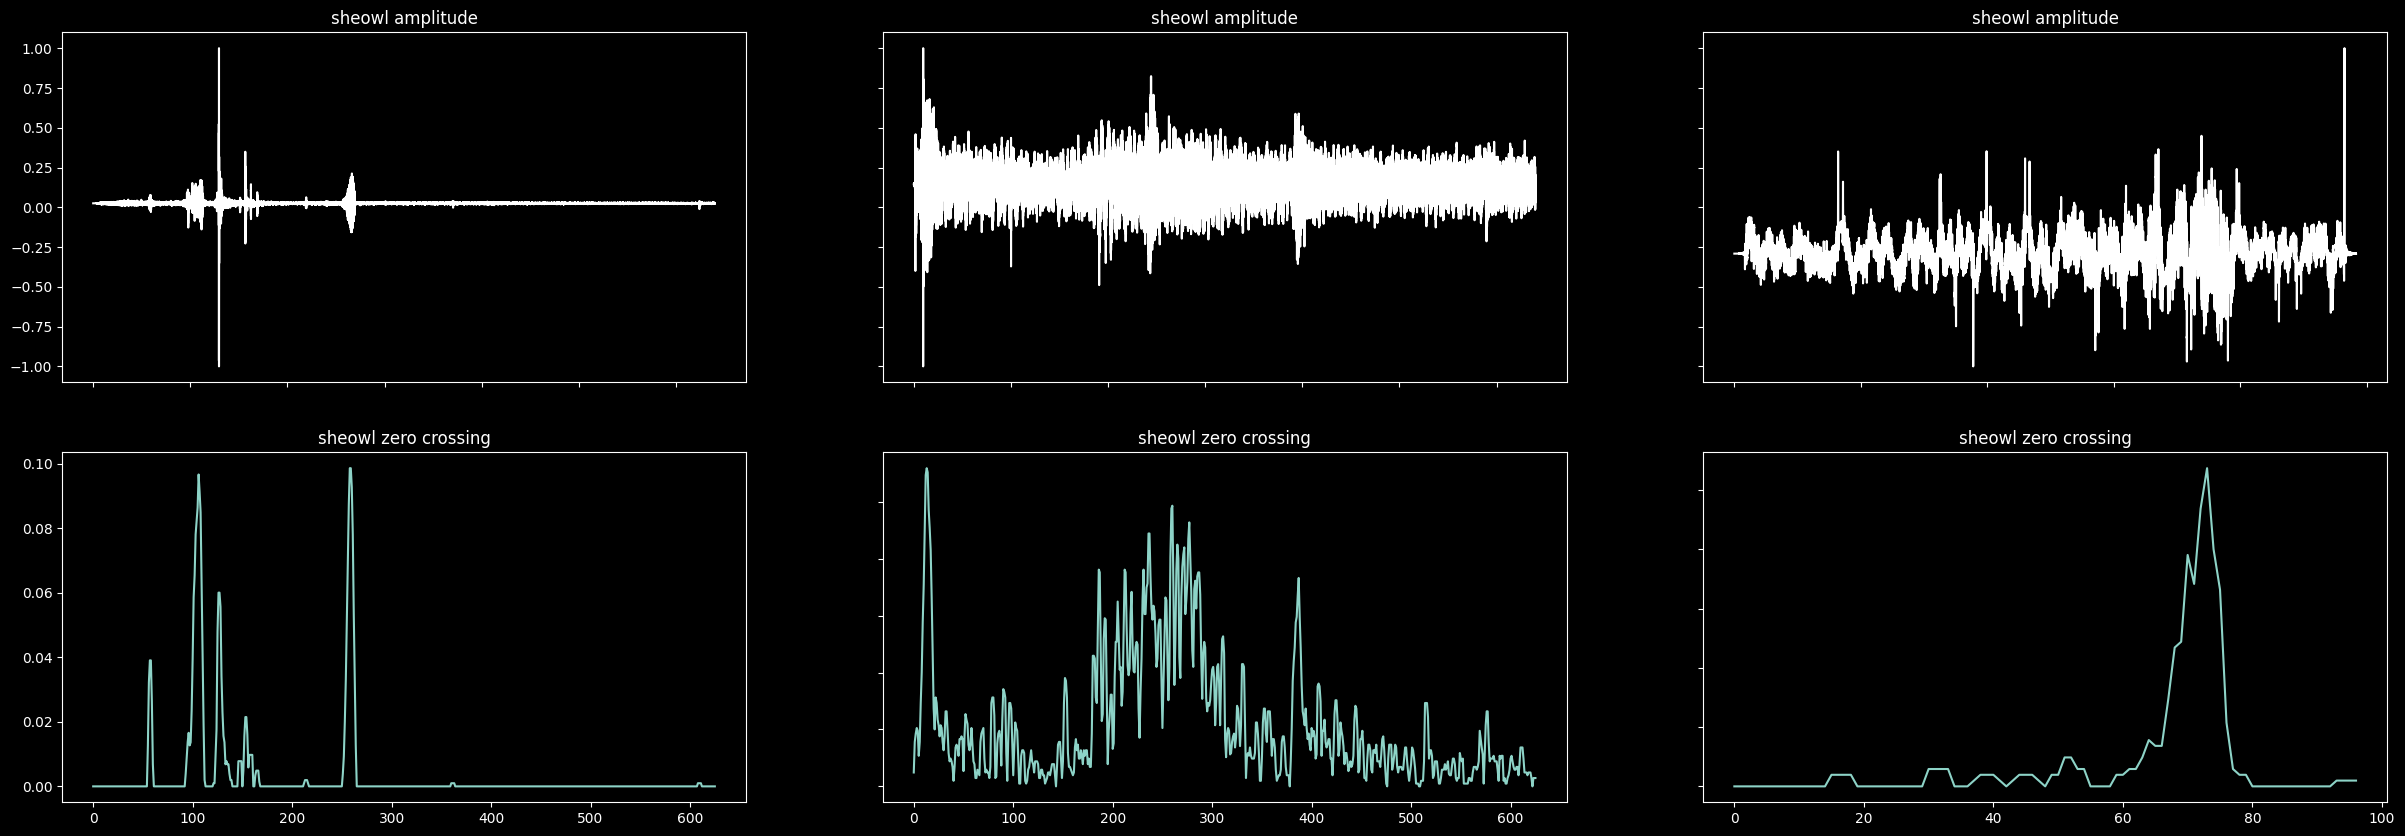

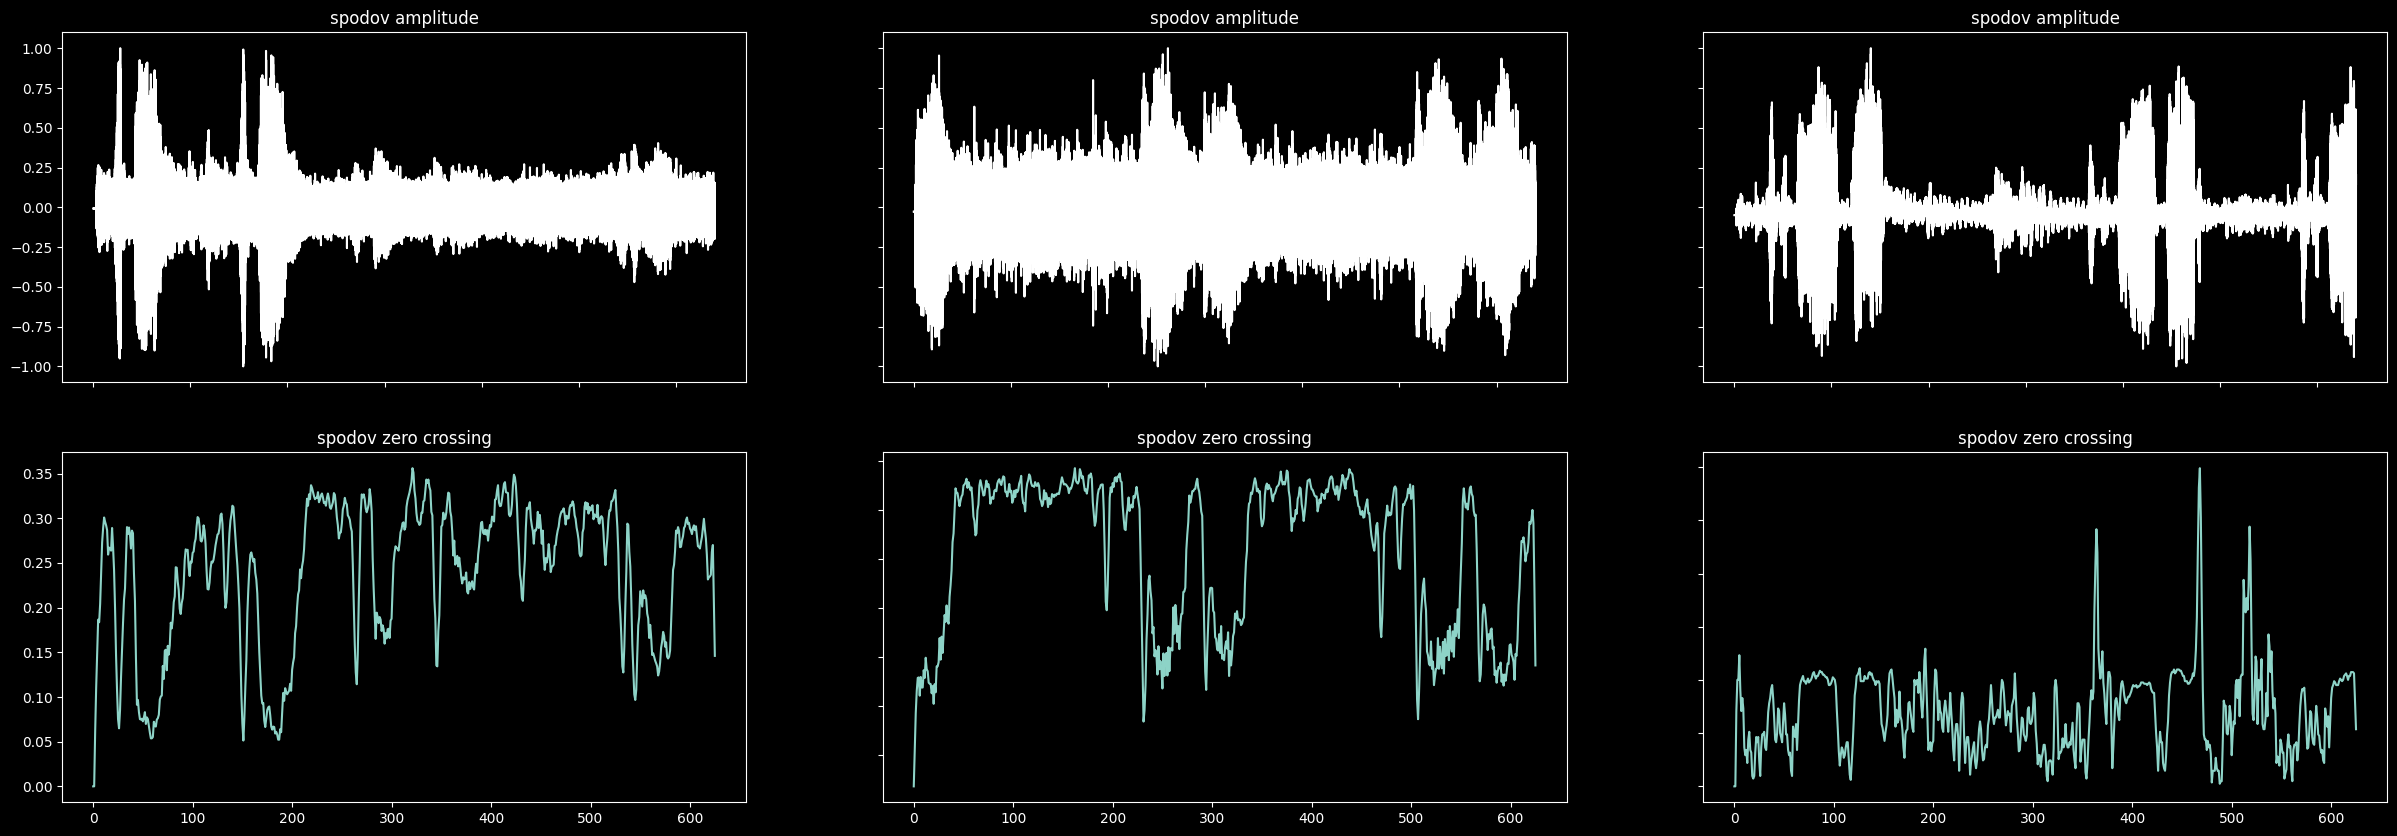

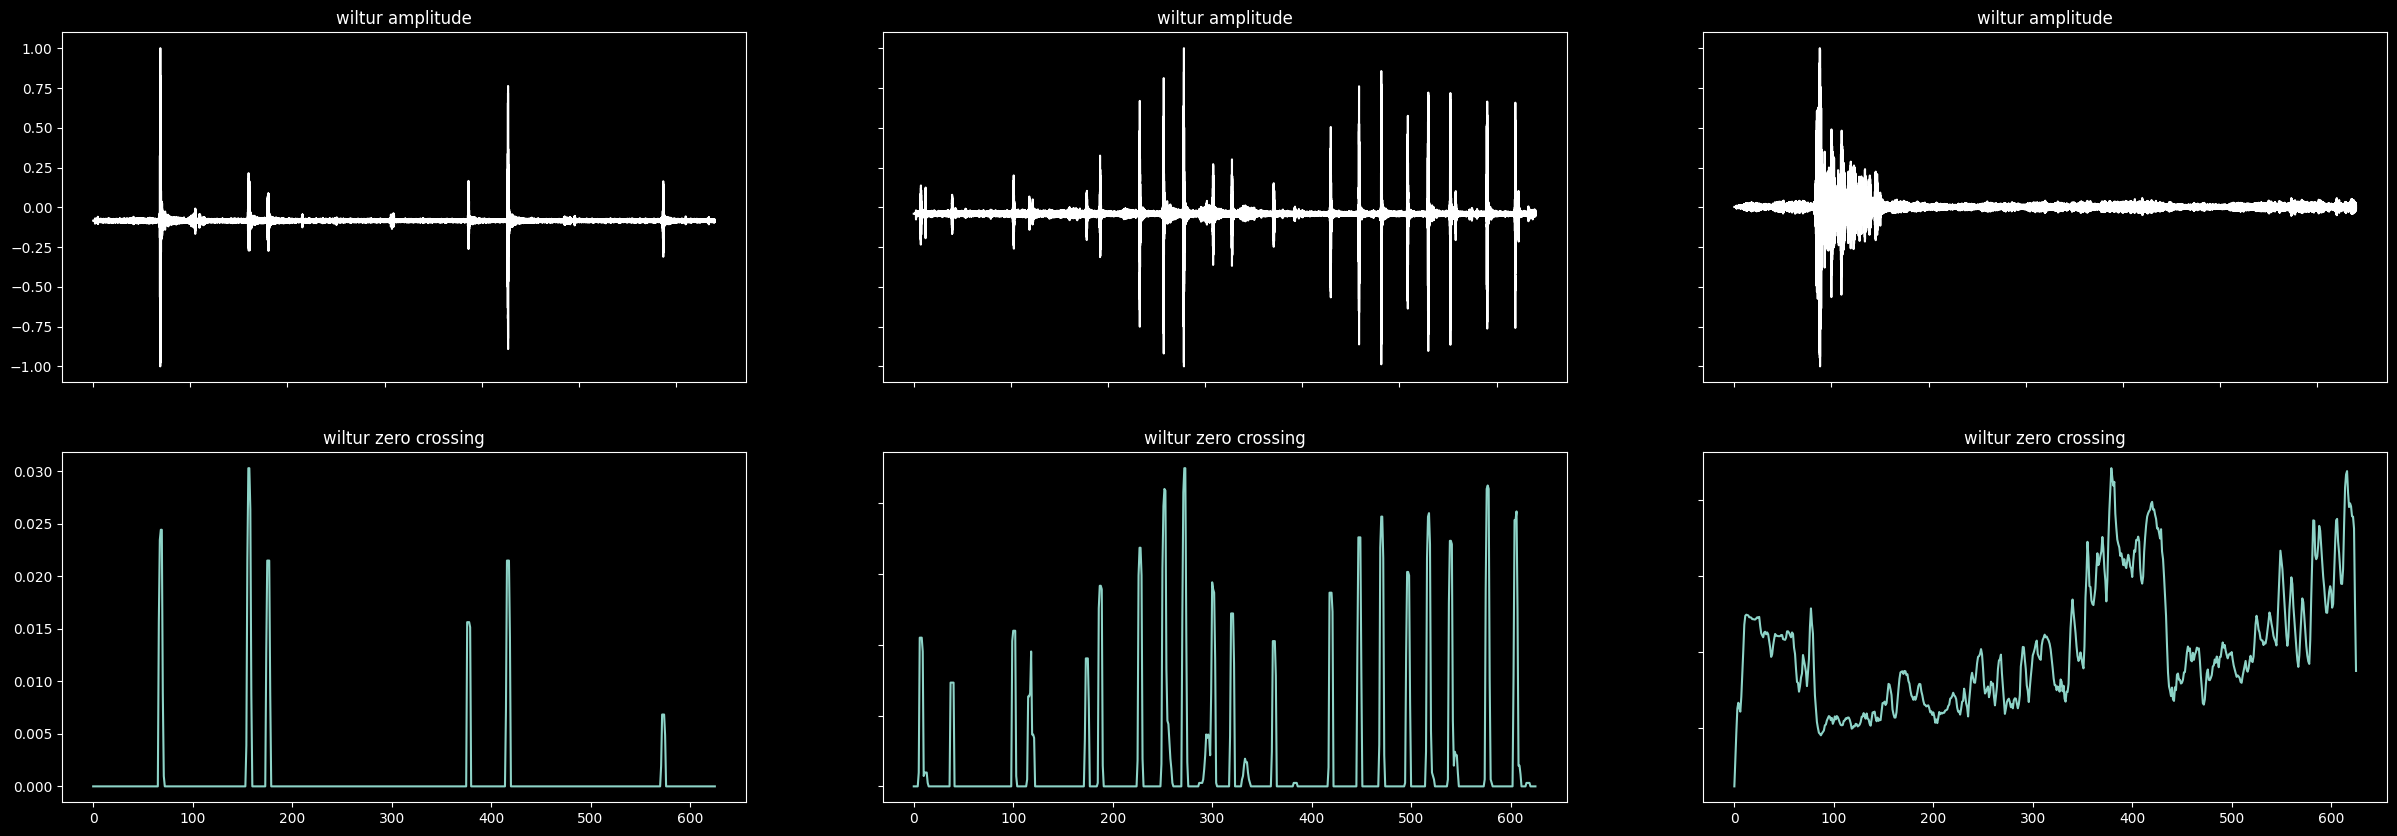

In [14]:
# plot three samples of audio from each target class
N_COLS=3

for target_index, target in enumerate(target_datasets.keys()):
    
    # create a pipeline to load the audio file
    audio_dataset = make_data_pipeline(target_datasets[target])
    
    # 2 rows per audio clip (3 columns one for each clip)
    fig, axs = plt.subplots(nrows=2, ncols=N_COLS, figsize=(30,10))
    
    for audio_index, (audio, rate, label) in enumerate(audio_dataset.take(N_COLS)):    

        # convert to numpy array
        audio_np = audio.numpy()[0:rate*CLIP_LENGTH]  
        axs[0, audio_index].plot(audio_np, color="white")    
        axs[0, audio_index].set_title(label.numpy().decode("utf-8") + " amplitude") 
        
        # zero crossing rate
        result = librosa.feature.zero_crossing_rate(audio_np)
        axs[1, audio_index].plot(result.squeeze())
        axs[1, audio_index].set_title(label.numpy().decode("utf-8") + " zero crossing") 
                
    for ax in axs.flat:
        ax.label_outer()